[View in Colaboratory](https://colab.research.google.com/github/NamitraKali/Stock-Price-Prediction/blob/master/RNN_Predictor.ipynb)

# Content
- <a href='#1'>1. Introduction</a>
  - <a href='#1.1'>1.1 Intro to the Stock Market</a>
  - <a href='#1.2'>1.2 Motivation</a>
- <a href='#2'>2. Imports and Exploring Data</a>
  - <a href='#2.1'>2.1 Importing Libraries and Data</a>
  - <a href='#2.2'>2.2 Exploring the Data</a>
- <a href='#3'>3. Manipulating the Data</a>
  - <a href='#3.1'>3.1 Extracting the Right Features</a>
  - <a href='#3.2'>3.2 Relative Strength Index (RSI)</a>
  - <a href='#3.3'>3.3 Moving Average Convergence Divergence (MACD)</a>
  - <a href='#3.4'>3.4 Stochastic Oscillator</a>
  - <a href='#3.5'>3.5 Average True Range (ATR)<a/>
  - <a href='#3.6'>3.6 Creating the Training/Testing Data</a>
- <a href='#4'>4. The Neural Network</a>
   - <a href='#4.1'>4.1 Our Neural Network Architecture</a>
   - <a href='#4.2'>4.2 Saving our Model</a>

<hr>
# <a id='1'>1. Introduction</a>

### <a id='1.1'>1.1 Intro to the Stock Market</a>
The Stock Exchange is a global marketplace where a momentous amount of money is moved around each day. What people buy from the stock market are shares from a company. These shares represent ownership of a company so in essence, the more shares that you own, the more influence you'd have over a company. After we buy a share, we could also sell it back to other people to make some money!
[!](<iframe width="560" height="315" src="https://www.youtube.com/embed/F3QpgXBtDeo?rel=0" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>)

In [4]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/F3QpgXBtDeo?rel=0" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

After hearing all this you might be wondering, why isn't everyone just buying shares and getting rich and why do people make it seem so hard to get into trading stocks? It should be similar to if I was buying and selling off any old antique on Ebay.

Well... The thing is, the price of a share changes based on a wide variety of factors. These could include news, social media prescence and internal company happenings. Due to the huge variation of things that could affect any given stock, we may as well think of the price of a stock to change randomly. In fact, for many years it was believed that the changes in the stock market were completely random!

### <a id='1.2'>1.2 Motivation</a>

Many big financial comapnies, such as Goldman Sachs, invest millions of dollars on trying to come up with predictive models to help them make more informed investments. With the help of Machine Learning even regular people, like us, can come up with powerful predictive models that can help us make more informed investments of our own.

This Jupyter Notebook will go through how we can organize stock data from Yahoo Finance so that we can run a Recurrent Neural Network through the data to predict the future prices of a Google Stock.

<hr>
# <a id='2'>2. Imports and Exploring Data</a>
### <a id='2.1'>2.1 Importing Libraries and Data</a>

In [5]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import pickle
from sklearn.model_selection import train_test_split
%matplotlib inline

from google.colab import files
uploaded = files.upload()

'''
# GPU stuff
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
'''

# Choose a style for our plots
# This style is clean
style.use('ggplot')

# Import our data and show how it looks
df = pd.read_csv('GOOGL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000
1,2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300
2,2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100
3,2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600


In [6]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3451,2018-05-04,1019.609985,1051.880005,1018.049988,1051.000000,1051.000000,1844600
3452,2018-05-07,1053.890015,1065.000000,1050.270020,1059.459961,1059.459961,1720000
3453,2018-05-08,1064.619995,1065.229980,1051.640015,1058.589966,1058.589966,1301500
3454,2018-05-09,1064.099976,1094.000000,1062.109985,1088.949951,1088.949951,2358000
3455,2018-05-10,1095.000000,1109.410034,1093.880005,1105.469971,1105.469971,1816600


### <a id='2.2'>2.2 Exploring the Data</a>

3456


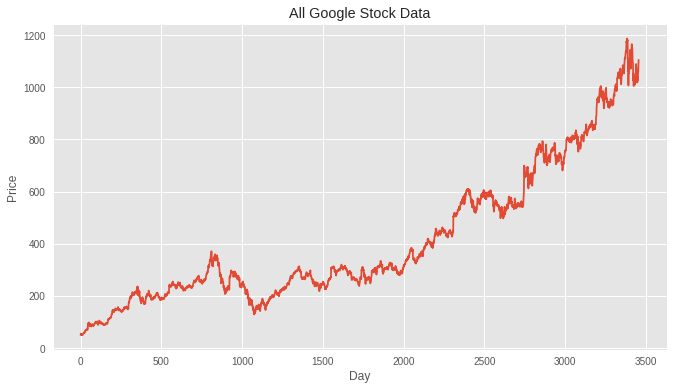

In [7]:
print(len(df))
# Since all of the data is correlated, except for volume
# we will only plot the Adj Close
plt.figure(figsize=(11,6))
df['Adj Close'].plot()
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('All Google Stock Data')
plt.show()

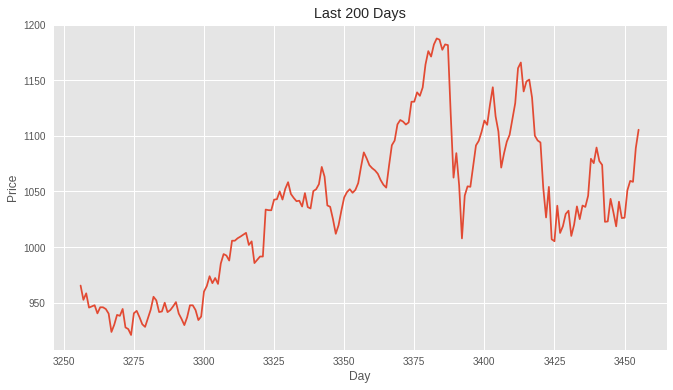

In [8]:
# Let's zoom in on the last 200 days to get a closer look
plt.figure(figsize=(11,6))
df['Adj Close'].iloc[-200:].plot()
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Last 200 Days')
plt.show()

<hr>
# <a id='3'>3. Manipulating the Data</a>
  ### <a id='3.1'>3.1 Extracting the Right Features</a>
  So now we've seen how the data looks. let's get to trimming out the unnecessary bits of information. For our dataset we'll only keep the Open and the Adj Close Prices. After that, we'll calculate the overall change in the stock price for that day. From there on we should be able to calculate some 'Technical Indicators' that could help us predict the movement of our stock.

In [9]:
# Let's add the Change, Gain and Loss
df['Change'] = df['Adj Close'] - df['Open']
df['Gain'] = (df['Change']).apply(lambda x: x if x>0 else 0)
df['Loss'] = (df['Change']).apply(lambda x: np.abs(x) if x<0 else 0)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Change,Gain,Loss
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000,0.170170,0.170170,0.000000
1,2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300,3.653652,3.653652,0.000000
2,2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100,-0.675678,0.000000,0.675678
3,2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300,-3.188186,0.000000,3.188186
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600,0.520523,0.520523,0.000000


  ### <a id='3.2'>3.2 Relative Strength Index (RSI)</a>
  The first Technical Indicator we're going to add to our dataset is called the Relative Strength Index (RSI). What the RSI does is show the speed and change of price movements. This is represented by a value between 0 and 100, when the value is below 30 the stock is considered oversold and a value of 70 means that the stock is overbought. To calculate the RSI we have to use the following formula.
  
$$RSI = 100 - \frac{100}{1 + RS}$$

where....

$$RS = \frac{\text{Average Gain}}{\text{Average Loss}}$$

This Average Gain/Loss uses the following formula.

$$\text{Average Gain/Loss} = \frac{[(\text{previous Gain/Loss}) \times 13 + \text{Current Gain/Loss}]}{14}$$

The important thing to see here is that the calculations for the Average Gain/Loss use the previous Average Gain/Loss. The advantage of using this measure, is that the more data we have, the more accurate this indicator becomes. Perfect for when we're working with Big Data!

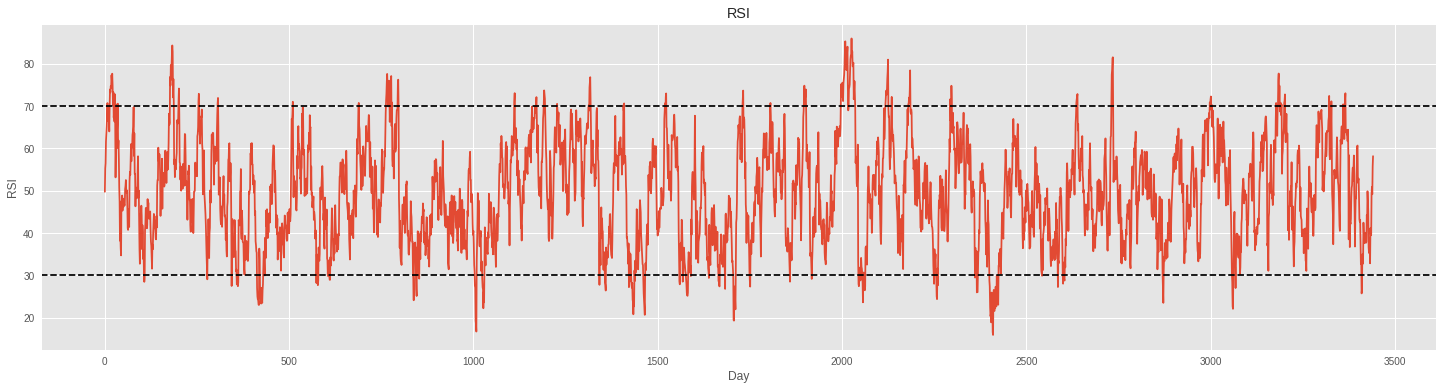

In [10]:
def RSI_calc(df, period):
  df = df.copy()
  
  first_avg_gain = np.sum(df['Gain'].iloc[:period]) / period
  first_avg_loss = np.sum(df['Loss'].iloc[:period]) / period
  
  # Each of these are indexed at df.iloc[period]
  avg_gain = [first_avg_gain]
  avg_loss = [first_avg_loss]
  
  # We need to start indexing at period+1
  for i in range(period+1, len(df)):
    avg_gain.append(((avg_gain[-1]*13) + df['Gain'].iloc[i]) / period)
    avg_loss.append(((avg_loss[-1]*13) + df['Loss'].iloc[i]) / period)
  
  avg_gain = pd.Series(avg_gain)
  avg_loss = pd.Series(avg_loss)
  
  RS = avg_gain / avg_loss
  
  RSI = 100 - (100 / (1 + RS))
  return RSI

plt.figure(figsize=(25, 6))
RSI_calc(df, 14).plot()
plt.axhline(70, linestyle='--', color='k')
plt.axhline(30, linestyle='--', color='k')
plt.title('RSI')
plt.xlabel('Day')
plt.ylabel('RSI')
plt.show()

  ### <a id='3.3'>3.3 Moving Average Convergence Divergence (MACD)</a>
  
  The second Technical Indicator we're going to use is the Moving Average Convergence Divergence (MACD). This is a very popular momentum oscillator. When the MACD has a positive value, that means that the stock is experiencing an upwards trend in price. Whereas, when it's negative it shows that the price is experiencing a downward trend. 
  
  To calculate the MACD we must first calculate a few Exponential Moving Averages (EMA) for a given period of days using the formula. If we use a shorter period of days, our EMA puts more emphasis on the most recent price, while a longer period puts less emphasis on the most recent days.
  
 $$EMA = [Close - \text{EMA(previous day)}] \times multiplier + \text{EMA(previous day)}$$
 
 
 $$multiplier = \frac{2}{period + 1}$$
 
  Then we use the EMA's as such to get our MACD value.
  
  $$\text{MACD Line} = \text{12-day EMA} - \text{26-day EMA}$$
  
  $$\text{Signal Line} = \text{9-day EMA}$$
  
  $$\text{MACD value} = \text{MACD Line} - \text{Signal Line}$$

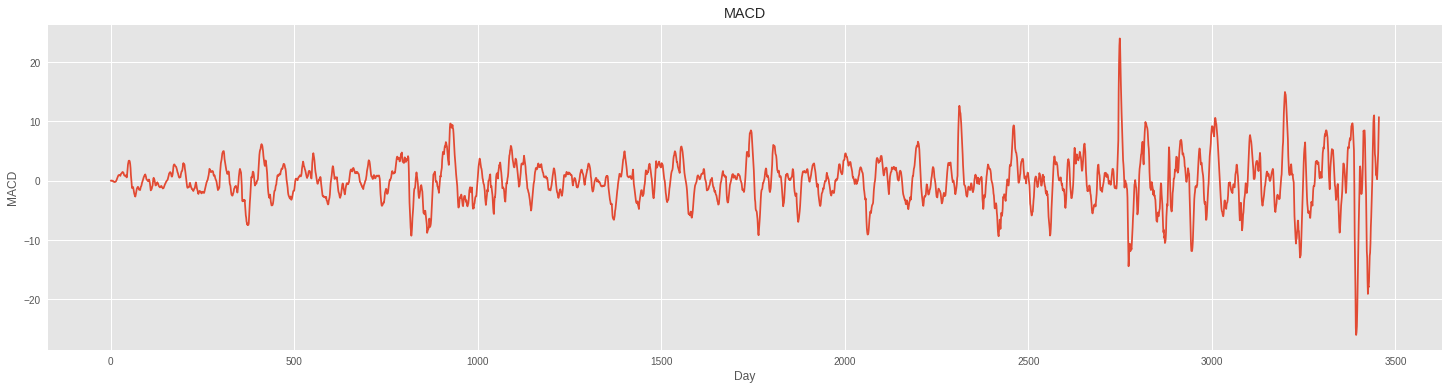

In [11]:
def MACD(df,period1,period2,periodSignal):
    EMA1 = pd.DataFrame.ewm(df['Adj Close'],span=period1).mean()
    EMA2 = pd.DataFrame.ewm(df['Adj Close'],span=period2).mean()
    MACD = EMA1-EMA2
    
    Signal = pd.DataFrame.ewm(MACD,periodSignal).mean()
    
    Histogram = MACD-Signal
    Histogram = pd.DataFrame(Histogram)
    Histogram.rename(columns={'Adj Close':'MACD'}, inplace=True)
    
    return Histogram

plt.figure(figsize=(25, 6))
MACD(df, 12, 26, 9)['MACD'].plot()
plt.title('MACD')
plt.xlabel('Day')
plt.ylabel('MACD')
plt.show()

  ### <a id='3.4'>3.4 Stochastic Oscillator</a>
  The third Technical Indicator we're going to add to our model is the Stochastic Oscillator. The gist of this is indicator is that if a stock is experiencing an upward trend, it will close near it's highest price, but during a downward trend it will close near it's lowest price. This method is very effective for stocks that are more choppy while - let's say - the RSI is better for market that follows a trend. The MACD would fall somewhere in the middle since it uses short-term data.
  
  The calculation for the Stochastic Oscillator looks like this...
  
  $$\%K = \frac{\text{Current Close} - \text{Lowest Low}}{\text{Highest High} - \text{Lowest Low}} \times 100\%$$

The use of a Simple Moving Average it often used to show when you should make a transaction.

$$\%D = \text{3-day SMA of } \%K$$

Text(0,0.5,'Stochastic Value')

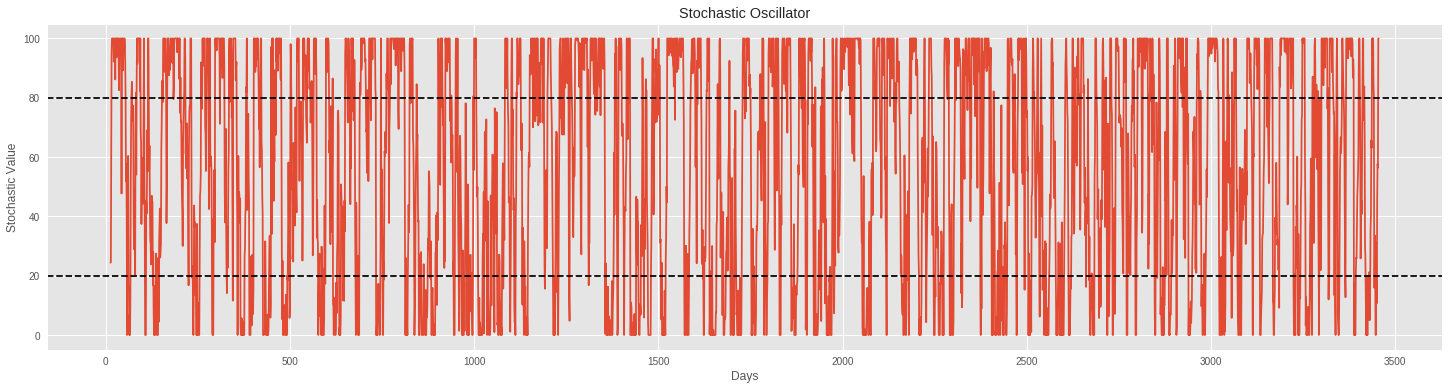

In [12]:
def stochastic(df, period):
    lows = pd.DataFrame.rolling(df['Adj Close'], period).min()
    highs = pd.DataFrame.rolling(df['Adj Close'], period).max()
    k = 100 * (df['Adj Close'] - lows) / (highs - lows)
    return k
  

# The plot looks kinda ugly, but it works!
plt.figure(figsize=(25, 6))
stochastic(df, 14).plot()
plt.title('Stochastic Oscillator')
plt.axhline(80, linestyle='--', color='k')
plt.axhline(20, linestyle='--', color='k')
plt.xlabel('Days')
plt.ylabel('Stochastic Value')


### <a id='3.5'>3.5 Average True Range (ATR)<a/>
  
The Average True Range is a measure of volatility. This picture shows 3 Methods of how to calculate it.

<img src='http://d.stockcharts.com/school/data/media/chart_school/technical_indicators_and_overlays/average_true_range_atr/atr-1-trexam.png'></img>

For our code we used Method A

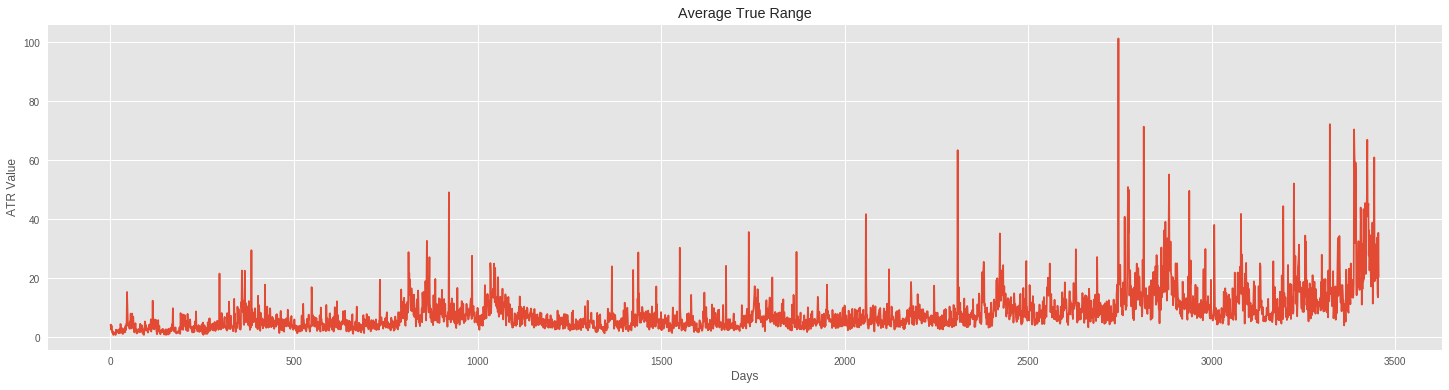

In [13]:
def ATR(df,period):
    '''
    Method A: Current High less the current Low
    '''
    df['H-L'] = abs(df['High']-df['Low'])
    df['H-PC'] = abs(df['High']-df['Close'].shift(1))
    df['L-PC'] = abs(df['Low']-df['Close'].shift(1))
    TR = df[['H-L','H-PC','L-PC']].max(axis=1)
    return TR.to_frame()
  
plt.figure(figsize=(25, 6))
ATR(df, 14)[0].plot()
plt.title('Average True Range')
plt.xlabel('Days')
plt.ylabel('ATR Value')
plt.show()

  ### <a id='3.6'>3.6 Creating the Training/Testing Data</a>

In [14]:
price = df[['Adj Close']].copy()
price['CloseTarget'] = price['Adj Close'].shift(-1)
price['RSI'] = RSI_calc(df, 14)
price['RSI'] = price['RSI'].shift(14)
price['MACD'] = MACD(price, 12, 26, 9)
price['Stochastic'] = stochastic(price, 14)
price['ATR'] = ATR(df, 14)
dataset = price.dropna()

dataset.to_csv('Google_TechnicalIndicators.csv', index=False)
#files.download('Google_TechnicalIndicators.csv')
dataset

,Adj Close,CloseTarget,RSI,MACD,Stochastic,ATR
14,51.206207,52.717716,49.738375,-0.114225,24.494186,0.855854
15,52.717716,53.803802,55.268755,-0.001091,56.656011,2.632633
16,53.803802,55.800800,56.471797,0.135798,94.810059,1.541542
17,55.800800,56.056057,61.632235,0.336023,100.000000,2.607609
18,56.056057,57.042042,63.302256,0.475649,100.000000,2.017018
19,57.042042,58.803802,65.151313,0.611604,100.000000,2.077076
20,58.803802,59.739738,68.382576,0.786588,100.000000,1.971969
21,59.739738,58.978977,70.680843,0.934261,100.000000,2.417420
22,58.978977,59.249249,66.430004,0.955601,92.144700,1.456459
23,59.249249,60.470470,67.477844,0.950625,94.935416,1.431431


#<a id='4'>4. The Neural Network</a>
So now that we have our dataset all ready to go, let's get to the fun part of building our model! The model we're going to use is a Recurrent Neural Network. The advantage of using a Recurrent Net is that they're built to predict the next value in time-series data. This means that if the order of our data matters, then Recurrent Neural Nets should perform really well on trying to predict the next values in our data. but first we gotta Normalize our data and split it into training and testing sets.

In [15]:
Normed_dataset = (dataset - dataset.mean()) / (dataset.max() - dataset.min())
Normed_dataset.head()

,Adj Close,CloseTarget,RSI,MACD,Stochastic,ATR
14,-0.320861,-0.320226,0.004290,-0.001895,-0.329905,-0.075664
15,-0.319531,-0.319269,0.083285,0.000369,-0.008287,-0.057961
16,-0.318575,-0.317509,0.100469,0.003109,0.373253,-0.068832
17,-0.316818,-0.317285,0.174180,0.007116,0.425153,-0.058210
18,-0.316593,-0.316416,0.198034,0.009910,0.425153,-0.064095


In [0]:
#Splitting the data into train and test sets
X = Normed_dataset[['Adj Close', 'RSI', 'MACD', 'Stochastic', 'ATR']]
Y = Normed_dataset[['CloseTarget']]

#Splits the data so that we have 100 testing samples
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=100, shuffle=False)

let's plot our training data and our testing data to get a sense of what we should expect to see

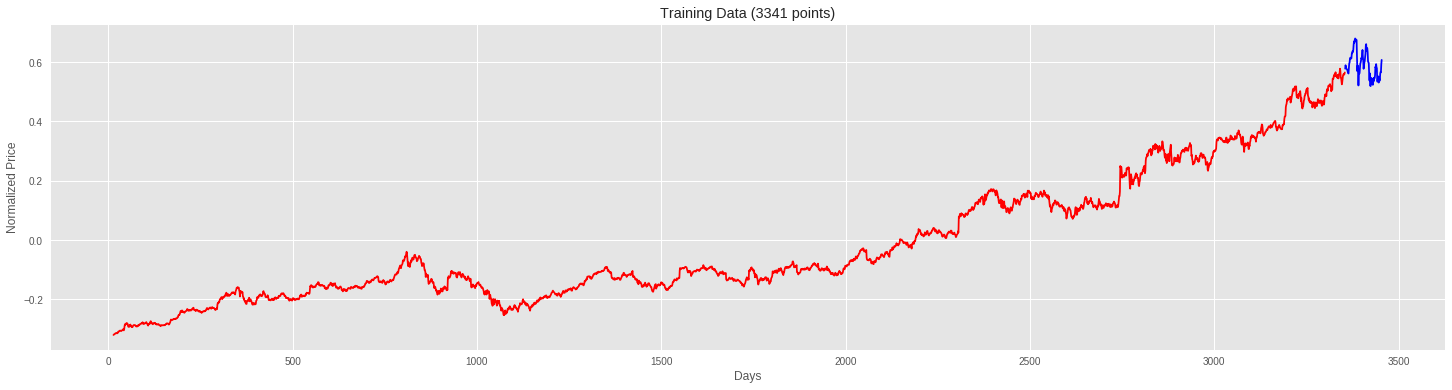

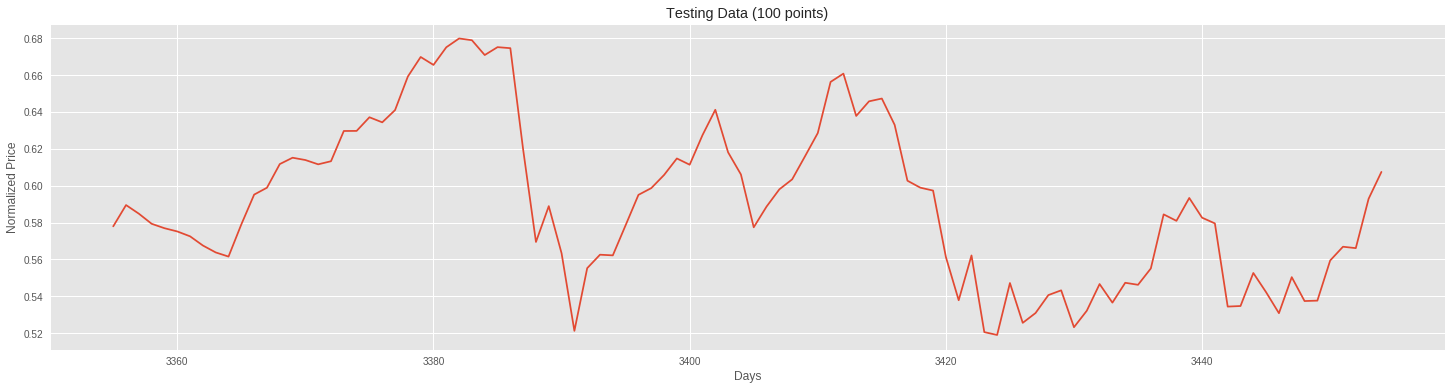

In [17]:
plt.figure(figsize=(25, 6))
trainY['CloseTarget'].plot(color='red', label='training')
testY['CloseTarget'].plot(color='blue', label='testing')
plt.title('Training Data ({} points)'.format(len(trainY)))
plt.xlabel('Days')
plt.ylabel('Normalized Price')
plt.show()

plt.figure(figsize=(25, 6))
testY['CloseTarget'].plot()
plt.title('Testing Data ({} points)'.format(len(testY)))
plt.xlabel('Days')
plt.ylabel('Normalized Price')
plt.show()

In [18]:
# Hyperparameters
samples = len(trainX) # how many data points do we have
time_steps = 1 # how far do we look back in time
features = len(trainX.columns) # how many columns are in our training data
print(samples, time_steps, features)

# convert our pandas dataframes into matrices
trainX = trainX.as_matrix()
trainY = trainY.as_matrix()

3341 1 5


### <a id='4.1'>4.1 Our Neural Network Architecture</a>

The type of Neural Network we're going to use is a Recurrent Network. A Recurrent Network allows data from past values persist in the network. This allows it to be incredibly good at predicting values in sequence or time-series data, so data where the order of each point is important. This is perfect for stock data!

<img src='https://cdn-images-1.medium.com/max/1600/0*WdbXF_e8kZI1R5nQ.png'></img>

This new Recurrent Network sounds great and all but, there's one problem with them, as values persist in the network their influence on the model decreases over time. This is known as the vanishing gradient problem. To fix this we're going to use a special Recurrent Network called a Long-Short Term Memory (LSTM) Network. This solves the vanishing gradient problem by employing some clever math tricks that wont be explained for now.

Now let's get to building our model and training it!

In [182]:
# Our input data for an LSTM has to have the shape (samples, time_steps, feature)
trainX = trainX.reshape(samples, time_steps, features)
print(trainX.shape[1:])

(1, 5)
3341
3341


In [183]:
# Now let's build our model
model = Sequential()
model.add(LSTM(5, input_shape=trainX.shape[1:])) # LSTM Layer with 5 nodes
model.add(Dense(5)) # Regular fully connected layer with 5 nodes
model.add(Dense(1)) # Output layer with 1 node to represent predicted price

# Mean Squared Error is a really good loss function for Regression problems
model.compile(loss='mean_squared_error', optimizer='adam')

# We'll train our model for 1000 epochs
# and it will take each point one at a time
performance = model.fit(trainX, trainY, epochs=1000, batch_size=1)

Epoch 1/1000
3341/3341 [==============================] - 34s 10ms/step - loss: 0.0026
Epoch 2/1000
1789/3341 [===============>..............] - ETA: 14s - loss: 7.0769e-05

3341/3341 [==============================] - 31s 9ms/step - loss: 7.3251e-05
Epoch 3/1000
2875/3341 [========================>.....] - ETA: 4s - loss: 8.1715e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 7.7641e-05
Epoch 4/1000
3341/3341 [==============================] - 32s 9ms/step - loss: 7.7061e-05


Epoch 5/1000
3341/3341 [==============================] - 32s 9ms/step - loss: 6.8837e-05
Epoch 6/1000
1682/3341 [==============>...............] - ETA: 15s - loss: 6.8276e-05

3341/3341 [==============================] - 31s 9ms/step - loss: 6.7456e-05
Epoch 7/1000
2848/3341 [========================>.....] - ETA: 4s - loss: 7.2677e-05

3341/3341 [==============================] - 31s 9ms/step - loss: 7.3070e-05
Epoch 8/1000
3341/3341 [==============================] - 31s 9ms/step - loss: 6.6988e-05
Epoch 9/1000
  13/3341 [..............................] - ETA: 30s - loss: 3.1301e-05

3341/3341 [==============================] - 31s 9ms/step - loss: 6.7405e-05
Epoch 10/1000
2093/3341 [=================>............] - ETA: 11s - loss: 7.3514e-05

3341/3341 [==============================] - 31s 9ms/step - loss: 6.9056e-05
Epoch 11/1000
3009/3341 [==========================>...] - ETA: 3s - loss: 6.7525e-05

3341/3341 [==============================] - 31s 9ms/step - loss: 6.6398e-05
Epoch 12/1000
3341/3341 [==============================] - 31s 9ms/step - loss: 6.8096e-05
Epoch 13/1000
  35/3341 [..............................] - ETA: 31s - loss: 5.7452e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 6.4215e-05
Epoch 14/1000
2092/3341 [=================>............] - ETA: 11s - loss: 6.1280e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 6.4537e-05
Epoch 15/1000
3028/3341 [==========================>...] - ETA: 2s - loss: 6.2801e-05

3341/3341 [==============================] - 31s 9ms/step - loss: 6.4340e-05
Epoch 16/1000
3341/3341 [==============================] - 31s 9ms/step - loss: 6.1522e-05
Epoch 17/1000
  36/3341 [..............................] - ETA: 30s - loss: 5.1362e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 6.2729e-05
Epoch 18/1000
2091/3341 [=================>............] - ETA: 11s - loss: 6.4467e-05

3341/3341 [==============================] - 31s 9ms/step - loss: 6.5327e-05
Epoch 19/1000
2998/3341 [=========================>....] - ETA: 3s - loss: 6.0768e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 6.0813e-05
Epoch 20/1000
3341/3341 [==============================] - 31s 9ms/step - loss: 6.2301e-05
Epoch 21/1000
  30/3341 [..............................] - ETA: 31s - loss: 3.0251e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 6.1973e-05
Epoch 22/1000
2101/3341 [=================>............] - ETA: 11s - loss: 6.4002e-05

3341/3341 [==============================] - 31s 9ms/step - loss: 6.1255e-05
Epoch 23/1000
3039/3341 [==========================>...] - ETA: 2s - loss: 6.1574e-05

3341/3341 [==============================] - 31s 9ms/step - loss: 6.0848e-05
Epoch 24/1000
3341/3341 [==============================] - 31s 9ms/step - loss: 6.2993e-05
Epoch 25/1000
  53/3341 [..............................] - ETA: 31s - loss: 3.4434e-05

3341/3341 [==============================] - 31s 9ms/step - loss: 6.0669e-05
Epoch 26/1000
2080/3341 [=================>............] - ETA: 11s - loss: 6.3936e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 6.0499e-05
Epoch 27/1000
2947/3341 [=========================>....] - ETA: 3s - loss: 6.2139e-05

3341/3341 [==============================] - 31s 9ms/step - loss: 6.1305e-05
Epoch 28/1000
3333/3341 [============================>.] - ETA: 0s - loss: 6.0727e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 6.0688e-05
Epoch 29/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 6.2043e-05
Epoch 30/1000
  63/3341 [..............................] - ETA: 31s - loss: 4.0728e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.8154e-05
Epoch 31/1000
2020/3341 [=================>............] - ETA: 12s - loss: 6.3101e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 6.2052e-05
Epoch 32/1000
2893/3341 [========================>.....] - ETA: 4s - loss: 6.2463e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 6.2712e-05
Epoch 33/1000
3286/3341 [============================>.] - ETA: 0s - loss: 6.2304e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 6.2108e-05
Epoch 34/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 5.9234e-05
Epoch 35/1000
  63/3341 [..............................] - ETA: 31s - loss: 8.4081e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 6.0224e-05
Epoch 36/1000
2033/3341 [=================>............] - ETA: 12s - loss: 6.1549e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 6.0232e-05
Epoch 37/1000
2916/3341 [=========================>....] - ETA: 4s - loss: 5.8374e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 6.1167e-05
Epoch 38/1000
3294/3341 [============================>.] - ETA: 0s - loss: 6.1810e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 6.2046e-05
Epoch 39/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 6.0907e-05
Epoch 40/1000
  68/3341 [..............................] - ETA: 32s - loss: 8.7133e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.8208e-05
Epoch 41/1000
2034/3341 [=================>............] - ETA: 12s - loss: 6.2574e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.9948e-05
Epoch 42/1000
2905/3341 [=========================>....] - ETA: 4s - loss: 6.0854e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 6.1291e-05
Epoch 43/1000
3284/3341 [============================>.] - ETA: 0s - loss: 6.0615e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 6.0111e-05
Epoch 44/1000
3341/3341 [==============================] - 32s 9ms/step - loss: 6.0637e-05
Epoch 45/1000
  71/3341 [..............................] - ETA: 30s - loss: 4.3191e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.9804e-05
Epoch 46/1000
2040/3341 [=================>............] - ETA: 12s - loss: 5.6480e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.9778e-05
Epoch 47/1000
2895/3341 [========================>.....] - ETA: 4s - loss: 5.9158e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.7907e-05
Epoch 48/1000
3283/3341 [============================>.] - ETA: 0s - loss: 5.8711e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.8606e-05
Epoch 49/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 6.0346e-05
Epoch 50/1000
  53/3341 [..............................] - ETA: 30s - loss: 9.9729e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 6.1297e-05
Epoch 51/1000
2018/3341 [=================>............] - ETA: 12s - loss: 5.5567e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.7345e-05
Epoch 52/1000
2892/3341 [========================>.....] - ETA: 4s - loss: 5.3856e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.7807e-05
Epoch 53/1000
3290/3341 [============================>.] - ETA: 0s - loss: 5.4605e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.4834e-05
Epoch 54/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 5.3230e-05
Epoch 55/1000
  52/3341 [..............................] - ETA: 31s - loss: 9.3323e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.4006e-05
Epoch 56/1000
2056/3341 [=================>............] - ETA: 12s - loss: 4.9469e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 5.3987e-05
Epoch 57/1000
2917/3341 [=========================>....] - ETA: 4s - loss: 5.3621e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.3855e-05
Epoch 58/1000
3297/3341 [============================>.] - ETA: 0s - loss: 5.3262e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 5.3036e-05
Epoch 59/1000
3341/3341 [==============================] - 32s 9ms/step - loss: 5.2755e-05
Epoch 60/1000
  87/3341 [..............................] - ETA: 31s - loss: 2.4659e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 5.0681e-05
Epoch 61/1000
2055/3341 [=================>............] - ETA: 12s - loss: 5.8899e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 5.2957e-05
Epoch 62/1000
2941/3341 [=========================>....] - ETA: 3s - loss: 5.2872e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.1705e-05
Epoch 63/1000
3316/3341 [============================>.] - ETA: 0s - loss: 5.4448e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.4325e-05
Epoch 64/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 5.0887e-05
Epoch 65/1000
  70/3341 [..............................] - ETA: 31s - loss: 9.1262e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 5.2025e-05
Epoch 66/1000
2046/3341 [=================>............] - ETA: 12s - loss: 4.8161e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.2399e-05
Epoch 67/1000
2926/3341 [=========================>....] - ETA: 3s - loss: 4.9910e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 4.9349e-05
Epoch 68/1000
3337/3341 [============================>.] - ETA: 0s - loss: 5.1247e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 5.1311e-05
Epoch 69/1000
3341/3341 [==============================] - 31s 9ms/step - loss: 5.1587e-05
Epoch 70/1000
 117/3341 [>.............................] - ETA: 30s - loss: 4.7173e-05

3341/3341 [==============================] - 31s 9ms/step - loss: 5.1459e-05
Epoch 71/1000
2083/3341 [=================>............] - ETA: 12s - loss: 5.0022e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 5.1626e-05
Epoch 72/1000
3045/3341 [==========================>...] - ETA: 2s - loss: 5.2152e-05

3341/3341 [==============================] - 31s 9ms/step - loss: 5.0730e-05
Epoch 73/1000
3341/3341 [==============================] - 31s 9ms/step - loss: 5.2255e-05
Epoch 74/1000
  84/3341 [..............................] - ETA: 29s - loss: 7.0080e-05

3341/3341 [==============================] - 31s 9ms/step - loss: 5.0186e-05
Epoch 75/1000
2108/3341 [=================>............] - ETA: 11s - loss: 4.9603e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 4.9060e-05
Epoch 76/1000
2960/3341 [=========================>....] - ETA: 3s - loss: 5.1296e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.2416e-05
Epoch 77/1000
3312/3341 [============================>.] - ETA: 0s - loss: 5.0379e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.0083e-05
Epoch 78/1000
3341/3341 [==============================] - 32s 9ms/step - loss: 5.0579e-05
Epoch 79/1000
  83/3341 [..............................] - ETA: 30s - loss: 3.8875e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.0880e-05
Epoch 80/1000
2025/3341 [=================>............] - ETA: 12s - loss: 5.2710e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 5.0003e-05
Epoch 81/1000
2913/3341 [=========================>....] - ETA: 4s - loss: 5.0792e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.9556e-05
Epoch 82/1000
3299/3341 [============================>.] - ETA: 0s - loss: 4.8166e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 4.7920e-05
Epoch 83/1000
3341/3341 [==============================] - 32s 9ms/step - loss: 4.9537e-05
Epoch 84/1000
  85/3341 [..............................] - ETA: 31s - loss: 4.2485e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.9710e-05
Epoch 85/1000
2035/3341 [=================>............] - ETA: 12s - loss: 4.4910e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.8104e-05
Epoch 86/1000
2922/3341 [=========================>....] - ETA: 3s - loss: 4.9672e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 4.8734e-05
Epoch 87/1000
3334/3341 [============================>.] - ETA: 0s - loss: 5.0273e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 5.0244e-05
Epoch 88/1000
3341/3341 [==============================] - 32s 9ms/step - loss: 4.9592e-05
Epoch 89/1000
 109/3341 [..............................] - ETA: 30s - loss: 4.1421e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.9579e-05
Epoch 90/1000
2065/3341 [=================>............] - ETA: 12s - loss: 5.0968e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.8568e-05
Epoch 91/1000
2917/3341 [=========================>....] - ETA: 4s - loss: 4.7374e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.8738e-05
Epoch 92/1000
3302/3341 [============================>.] - ETA: 0s - loss: 4.8664e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 4.9189e-05
Epoch 93/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.9242e-05
Epoch 94/1000
  76/3341 [..............................] - ETA: 30s - loss: 5.0236e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 5.0336e-05
Epoch 95/1000
2065/3341 [=================>............] - ETA: 12s - loss: 4.2869e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 4.8696e-05
Epoch 96/1000
2961/3341 [=========================>....] - ETA: 3s - loss: 4.6725e-05

3341/3341 [==============================] - 31s 9ms/step - loss: 4.9021e-05
Epoch 97/1000
3333/3341 [============================>.] - ETA: 0s - loss: 4.7892e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7794e-05
Epoch 98/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.8206e-05
Epoch 99/1000
  70/3341 [..............................] - ETA: 31s - loss: 4.7591e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.9575e-05
Epoch 100/1000
2017/3341 [=================>............] - ETA: 12s - loss: 4.5804e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.8685e-05
Epoch 101/1000
2874/3341 [========================>.....] - ETA: 4s - loss: 4.3411e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6642e-05
Epoch 102/1000
3250/3341 [============================>.] - ETA: 0s - loss: 4.8325e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.9789e-05
Epoch 103/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.8947e-05
Epoch 104/1000
  41/3341 [..............................] - ETA: 33s - loss: 4.7763e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7370e-05
Epoch 105/1000
2008/3341 [=================>............] - ETA: 12s - loss: 4.3980e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.8619e-05
Epoch 106/1000
2870/3341 [========================>.....] - ETA: 4s - loss: 4.4783e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7185e-05
Epoch 107/1000
3232/3341 [============================>.] - ETA: 1s - loss: 4.7757e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7363e-05
Epoch 108/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.6765e-05
Epoch 109/1000
  36/3341 [..............................] - ETA: 32s - loss: 3.5686e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7069e-05
Epoch 110/1000
2000/3341 [================>.............] - ETA: 12s - loss: 4.4088e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.9037e-05
Epoch 111/1000
2857/3341 [========================>.....] - ETA: 4s - loss: 4.7020e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6447e-05
Epoch 112/1000
3216/3341 [===========================>..] - ETA: 1s - loss: 4.8826e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.8403e-05
Epoch 113/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.7596e-05
Epoch 114/1000
  29/3341 [..............................] - ETA: 32s - loss: 3.6974e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.8286e-05
Epoch 115/1000
1990/3341 [================>.............] - ETA: 13s - loss: 4.5136e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.9904e-05
Epoch 116/1000
2857/3341 [========================>.....] - ETA: 4s - loss: 4.7827e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7003e-05
Epoch 117/1000
3206/3341 [===========================>..] - ETA: 1s - loss: 4.6239e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7275e-05
Epoch 118/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.8152e-05
Epoch 119/1000
   1/3341 [..............................] - ETA: 39s - loss: 7.8085e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.9299e-05
Epoch 120/1000
1972/3341 [================>.............] - ETA: 13s - loss: 5.1180e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.8170e-05
Epoch 121/1000
2839/3341 [========================>.....] - ETA: 4s - loss: 4.5732e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7448e-05
Epoch 122/1000
3227/3341 [===========================>..] - ETA: 1s - loss: 4.6687e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6960e-05
Epoch 123/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.6606e-05
Epoch 124/1000
   7/3341 [..............................] - ETA: 32s - loss: 2.6005e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7745e-05
Epoch 125/1000
1987/3341 [================>.............] - ETA: 12s - loss: 4.4650e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6297e-05
Epoch 126/1000
2854/3341 [========================>.....] - ETA: 4s - loss: 4.6338e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7382e-05
Epoch 127/1000
3247/3341 [============================>.] - ETA: 0s - loss: 4.7303e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7011e-05
Epoch 128/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.8721e-05
Epoch 129/1000
  23/3341 [..............................] - ETA: 32s - loss: 2.6496e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.8803e-05
Epoch 130/1000
1995/3341 [================>.............] - ETA: 12s - loss: 4.8493e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6989e-05
Epoch 131/1000
2850/3341 [========================>.....] - ETA: 4s - loss: 4.5483e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7566e-05
Epoch 132/1000
3230/3341 [============================>.] - ETA: 1s - loss: 4.6395e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5980e-05
Epoch 133/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.5637e-05
Epoch 134/1000
  35/3341 [..............................] - ETA: 31s - loss: 3.5399e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.8190e-05
Epoch 135/1000
2005/3341 [=================>............] - ETA: 12s - loss: 4.5103e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.8161e-05
Epoch 136/1000
2864/3341 [========================>.....] - ETA: 4s - loss: 4.5993e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.8023e-05
Epoch 137/1000
3239/3341 [============================>.] - ETA: 0s - loss: 4.7378e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7129e-05
Epoch 138/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.6551e-05
Epoch 139/1000
  18/3341 [..............................] - ETA: 31s - loss: 1.9055e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.8432e-05
Epoch 140/1000
2003/3341 [================>.............] - ETA: 12s - loss: 4.3255e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7257e-05
Epoch 141/1000
2869/3341 [========================>.....] - ETA: 4s - loss: 4.7309e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7553e-05
Epoch 142/1000
3248/3341 [============================>.] - ETA: 0s - loss: 4.7278e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6974e-05
Epoch 143/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.6580e-05
Epoch 144/1000
  41/3341 [..............................] - ETA: 32s - loss: 6.8373e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6562e-05
Epoch 145/1000
2001/3341 [================>.............] - ETA: 12s - loss: 4.6007e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6149e-05
Epoch 146/1000
2880/3341 [========================>.....] - ETA: 4s - loss: 4.6940e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6543e-05
Epoch 147/1000
3230/3341 [============================>.] - ETA: 1s - loss: 4.6651e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6306e-05
Epoch 148/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.6798e-05
Epoch 149/1000
  18/3341 [..............................] - ETA: 32s - loss: 3.4876e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6784e-05
Epoch 150/1000
1977/3341 [================>.............] - ETA: 13s - loss: 4.5299e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6825e-05
Epoch 151/1000
2859/3341 [========================>.....] - ETA: 4s - loss: 4.7594e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6793e-05
Epoch 152/1000
3232/3341 [============================>.] - ETA: 1s - loss: 4.5681e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6636e-05
Epoch 153/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.7976e-05
Epoch 154/1000
  13/3341 [..............................] - ETA: 29s - loss: 4.6188e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5258e-05
Epoch 155/1000
2013/3341 [=================>............] - ETA: 12s - loss: 4.6842e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5402e-05
Epoch 156/1000
2874/3341 [========================>.....] - ETA: 4s - loss: 4.8011e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6432e-05
Epoch 157/1000
3240/3341 [============================>.] - ETA: 0s - loss: 4.5789e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6788e-05
Epoch 158/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.7903e-05
Epoch 159/1000
  13/3341 [..............................] - ETA: 31s - loss: 8.7314e-06

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4641e-05
Epoch 160/1000
1980/3341 [================>.............] - ETA: 13s - loss: 5.0464e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6996e-05
Epoch 161/1000
2836/3341 [========================>.....] - ETA: 4s - loss: 4.7965e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7414e-05
Epoch 162/1000
3192/3341 [===========================>..] - ETA: 1s - loss: 4.7730e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7276e-05
Epoch 163/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.7324e-05


Epoch 164/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.7523e-05
Epoch 165/1000
1506/3341 [============>.................] - ETA: 18s - loss: 5.0208e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.6089e-05
Epoch 166/1000
2617/3341 [======================>.......] - ETA: 7s - loss: 4.6413e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5576e-05
Epoch 167/1000
3104/3341 [==========================>...] - ETA: 2s - loss: 4.6808e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6874e-05
Epoch 168/1000
3314/3341 [============================>.] - ETA: 0s - loss: 4.4874e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.5017e-05
Epoch 169/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.5537e-05
Epoch 170/1000
  29/3341 [..............................] - ETA: 32s - loss: 8.4446e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6590e-05
Epoch 171/1000
1995/3341 [================>.............] - ETA: 12s - loss: 4.4402e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5978e-05
Epoch 172/1000
2851/3341 [========================>.....] - ETA: 4s - loss: 4.6583e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5551e-05
Epoch 173/1000
3213/3341 [===========================>..] - ETA: 1s - loss: 4.5874e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5986e-05
Epoch 174/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.6607e-05
Epoch 175/1000
  17/3341 [..............................] - ETA: 36s - loss: 3.8761e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6425e-05
Epoch 176/1000
1967/3341 [================>.............] - ETA: 13s - loss: 4.8237e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.5526e-05
Epoch 177/1000
2815/3341 [========================>.....] - ETA: 5s - loss: 4.7126e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6956e-05
Epoch 178/1000
3214/3341 [===========================>..] - ETA: 1s - loss: 4.5355e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5642e-05
Epoch 179/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.7741e-05
Epoch 180/1000
  13/3341 [..............................] - ETA: 31s - loss: 4.3110e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4488e-05
Epoch 181/1000
1952/3341 [================>.............] - ETA: 13s - loss: 4.6586e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.5660e-05
Epoch 182/1000
2837/3341 [========================>.....] - ETA: 4s - loss: 4.5530e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4653e-05
Epoch 183/1000
3194/3341 [===========================>..] - ETA: 1s - loss: 4.6952e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6618e-05
Epoch 184/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.5828e-05
Epoch 185/1000
  12/3341 [..............................] - ETA: 32s - loss: 5.3050e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7733e-05
Epoch 186/1000
1953/3341 [================>.............] - ETA: 13s - loss: 4.5994e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6793e-05
Epoch 187/1000
2823/3341 [========================>.....] - ETA: 5s - loss: 4.1983e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5597e-05
Epoch 188/1000
3182/3341 [===========================>..] - ETA: 1s - loss: 4.5982e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.5528e-05
Epoch 189/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.4699e-05
Epoch 190/1000
   7/3341 [..............................] - ETA: 34s - loss: 1.9178e-05 

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7120e-05
Epoch 191/1000
2002/3341 [================>.............] - ETA: 12s - loss: 5.0941e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7172e-05
Epoch 192/1000
2856/3341 [========================>.....] - ETA: 4s - loss: 4.7235e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6211e-05
Epoch 193/1000
3201/3341 [===========================>..] - ETA: 1s - loss: 4.5489e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5767e-05
Epoch 194/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.6994e-05
Epoch 195/1000
  17/3341 [..............................] - ETA: 33s - loss: 8.4492e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5664e-05
Epoch 196/1000
1964/3341 [================>.............] - ETA: 13s - loss: 4.1440e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7051e-05
Epoch 197/1000
2831/3341 [========================>.....] - ETA: 4s - loss: 4.8518e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6932e-05
Epoch 198/1000
3225/3341 [===========================>..] - ETA: 1s - loss: 4.5474e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5448e-05
Epoch 199/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.6622e-05
Epoch 200/1000
  18/3341 [..............................] - ETA: 32s - loss: 3.5601e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.6406e-05
Epoch 201/1000
1987/3341 [================>.............] - ETA: 13s - loss: 4.1968e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.5384e-05
Epoch 202/1000
2851/3341 [========================>.....] - ETA: 4s - loss: 4.7241e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6082e-05
Epoch 203/1000
3211/3341 [===========================>..] - ETA: 1s - loss: 4.8542e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.7700e-05
Epoch 204/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.5154e-05
Epoch 205/1000
  18/3341 [..............................] - ETA: 32s - loss: 4.9963e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4156e-05
Epoch 206/1000
1956/3341 [================>.............] - ETA: 13s - loss: 4.8274e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.6948e-05
Epoch 207/1000
2813/3341 [========================>.....] - ETA: 5s - loss: 4.5412e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5514e-05
Epoch 208/1000
3184/3341 [===========================>..] - ETA: 1s - loss: 4.4939e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.5038e-05
Epoch 209/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.5177e-05
Epoch 210/1000
  12/3341 [..............................] - ETA: 33s - loss: 1.3292e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5020e-05
Epoch 211/1000
1970/3341 [================>.............] - ETA: 13s - loss: 4.4674e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.5152e-05
Epoch 212/1000
2814/3341 [========================>.....] - ETA: 5s - loss: 4.7022e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.5319e-05
Epoch 213/1000
3214/3341 [===========================>..] - ETA: 1s - loss: 4.5428e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5202e-05
Epoch 214/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.5368e-05
Epoch 215/1000
  12/3341 [..............................] - ETA: 33s - loss: 3.5834e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5507e-05
Epoch 216/1000
1964/3341 [================>.............] - ETA: 13s - loss: 3.6520e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.6084e-05
Epoch 217/1000
2836/3341 [========================>.....] - ETA: 4s - loss: 4.4983e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5135e-05
Epoch 218/1000
3202/3341 [===========================>..] - ETA: 1s - loss: 4.6626e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.6085e-05
Epoch 219/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.4788e-05
Epoch 220/1000
   7/3341 [..............................] - ETA: 34s - loss: 6.0397e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5823e-05
Epoch 221/1000
1958/3341 [================>.............] - ETA: 13s - loss: 4.5204e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5445e-05
Epoch 222/1000
2825/3341 [========================>.....] - ETA: 5s - loss: 4.8017e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.6098e-05
Epoch 223/1000
3179/3341 [===========================>..] - ETA: 1s - loss: 4.5741e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.5907e-05
Epoch 224/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3818e-05
Epoch 225/1000
  12/3341 [..............................] - ETA: 35s - loss: 2.2638e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.4236e-05
Epoch 226/1000
1958/3341 [================>.............] - ETA: 13s - loss: 4.7217e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4446e-05
Epoch 227/1000
2805/3341 [========================>.....] - ETA: 5s - loss: 4.5935e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.4870e-05
Epoch 228/1000
3186/3341 [===========================>..] - ETA: 1s - loss: 4.5920e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5640e-05
Epoch 229/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.5196e-05
Epoch 230/1000
   1/3341 [..............................] - ETA: 50s - loss: 2.9573e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5325e-05
Epoch 231/1000
1968/3341 [================>.............] - ETA: 13s - loss: 4.8292e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4755e-05
Epoch 232/1000
2842/3341 [========================>.....] - ETA: 4s - loss: 4.4861e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4887e-05
Epoch 233/1000
3161/3341 [===========================>..] - ETA: 1s - loss: 4.6803e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.6774e-05
Epoch 234/1000
3333/3341 [============================>.] - ETA: 0s - loss: 4.4745e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4838e-05
Epoch 235/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.4979e-05
Epoch 236/1000
  31/3341 [..............................] - ETA: 31s - loss: 7.4006e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.4747e-05
Epoch 237/1000
1982/3341 [================>.............] - ETA: 13s - loss: 4.6060e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4022e-05
Epoch 238/1000
2859/3341 [========================>.....] - ETA: 4s - loss: 4.5599e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4434e-05
Epoch 239/1000
3226/3341 [===========================>..] - ETA: 1s - loss: 4.4676e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4138e-05
Epoch 240/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.4776e-05
Epoch 241/1000
   1/3341 [..............................] - ETA: 53s - loss: 2.6270e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.4635e-05
Epoch 242/1000
1961/3341 [================>.............] - ETA: 13s - loss: 4.5394e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.4697e-05
Epoch 243/1000
2836/3341 [========================>.....] - ETA: 4s - loss: 4.2710e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.4578e-05
Epoch 244/1000
3187/3341 [===========================>..] - ETA: 1s - loss: 4.5021e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4199e-05
Epoch 245/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.4572e-05
Epoch 246/1000


3341/3341 [==============================] - 33s 10ms/step - loss: 4.4777e-05
Epoch 247/1000
1948/3341 [================>.............] - ETA: 13s - loss: 4.5626e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.5816e-05
Epoch 248/1000
2824/3341 [========================>.....] - ETA: 5s - loss: 4.4435e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4235e-05
Epoch 249/1000
3173/3341 [===========================>..] - ETA: 1s - loss: 4.4621e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.4228e-05
Epoch 250/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.4258e-05


Epoch 251/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3239e-05
Epoch 252/1000
1540/3341 [============>.................] - ETA: 17s - loss: 4.7539e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3981e-05
Epoch 253/1000
2634/3341 [======================>.......] - ETA: 6s - loss: 4.0455e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2954e-05
Epoch 254/1000
3114/3341 [==========================>...] - ETA: 2s - loss: 4.4143e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3872e-05
Epoch 255/1000
3312/3341 [============================>.] - ETA: 0s - loss: 4.4008e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3965e-05
Epoch 256/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.4983e-05
Epoch 257/1000
  47/3341 [..............................] - ETA: 32s - loss: 2.1347e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4266e-05
Epoch 258/1000
1988/3341 [================>.............] - ETA: 13s - loss: 4.6188e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3839e-05
Epoch 259/1000
2833/3341 [========================>.....] - ETA: 4s - loss: 4.3544e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2916e-05
Epoch 260/1000
3214/3341 [===========================>..] - ETA: 1s - loss: 4.2752e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3274e-05
Epoch 261/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2810e-05
Epoch 262/1000
   6/3341 [..............................] - ETA: 37s - loss: 2.9535e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3874e-05
Epoch 263/1000
1963/3341 [================>.............] - ETA: 13s - loss: 3.9655e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2968e-05
Epoch 264/1000
2822/3341 [========================>.....] - ETA: 5s - loss: 4.4349e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2421e-05
Epoch 265/1000
3192/3341 [===========================>..] - ETA: 1s - loss: 4.4509e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.4365e-05
Epoch 266/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3715e-05
Epoch 267/1000
   7/3341 [..............................] - ETA: 32s - loss: 1.5647e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3262e-05
Epoch 268/1000
1990/3341 [================>.............] - ETA: 13s - loss: 3.8554e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3748e-05
Epoch 269/1000
2854/3341 [========================>.....] - ETA: 4s - loss: 4.4193e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4770e-05
Epoch 270/1000
3228/3341 [===========================>..] - ETA: 1s - loss: 4.2559e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3043e-05
Epoch 271/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3402e-05
Epoch 272/1000
  23/3341 [..............................] - ETA: 32s - loss: 4.1487e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2748e-05
Epoch 273/1000
1997/3341 [================>.............] - ETA: 12s - loss: 4.0800e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2931e-05
Epoch 274/1000
2867/3341 [========================>.....] - ETA: 4s - loss: 4.4250e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3737e-05
Epoch 275/1000
3223/3341 [===========================>..] - ETA: 1s - loss: 4.3166e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2957e-05
Epoch 276/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.4188e-05
Epoch 277/1000
  31/3341 [..............................] - ETA: 31s - loss: 2.4313e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3733e-05
Epoch 278/1000
1995/3341 [================>.............] - ETA: 12s - loss: 4.1290e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4265e-05
Epoch 279/1000
2862/3341 [========================>.....] - ETA: 4s - loss: 4.0173e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2326e-05
Epoch 280/1000
3242/3341 [============================>.] - ETA: 0s - loss: 4.3105e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3079e-05
Epoch 281/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.5336e-05
Epoch 282/1000
  36/3341 [..............................] - ETA: 31s - loss: 3.1697e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2862e-05
Epoch 283/1000
2015/3341 [=================>............] - ETA: 12s - loss: 4.3873e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4201e-05
Epoch 284/1000
2878/3341 [========================>.....] - ETA: 4s - loss: 4.4898e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4135e-05
Epoch 285/1000
3237/3341 [============================>.] - ETA: 1s - loss: 4.3094e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3542e-05
Epoch 286/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.4602e-05
Epoch 287/1000
  18/3341 [..............................] - ETA: 32s - loss: 3.6971e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2745e-05
Epoch 288/1000
1963/3341 [================>.............] - ETA: 13s - loss: 3.9135e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3711e-05
Epoch 289/1000
2818/3341 [========================>.....] - ETA: 5s - loss: 4.3332e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3718e-05
Epoch 290/1000
3189/3341 [===========================>..] - ETA: 1s - loss: 4.3848e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3569e-05
Epoch 291/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2853e-05
Epoch 292/1000


3341/3341 [==============================] - 32s 10ms/step - loss: 4.2183e-05
Epoch 293/1000
1980/3341 [================>.............] - ETA: 13s - loss: 4.3481e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2712e-05
Epoch 294/1000
2849/3341 [========================>.....] - ETA: 4s - loss: 4.0528e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2733e-05
Epoch 295/1000
3234/3341 [============================>.] - ETA: 1s - loss: 4.1616e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3747e-05
Epoch 296/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3428e-05
Epoch 297/1000
  29/3341 [..............................] - ETA: 32s - loss: 3.9281e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4340e-05
Epoch 298/1000
1985/3341 [================>.............] - ETA: 13s - loss: 3.8381e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4274e-05
Epoch 299/1000
2859/3341 [========================>.....] - ETA: 4s - loss: 4.1396e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3476e-05
Epoch 300/1000
3238/3341 [============================>.] - ETA: 0s - loss: 4.4465e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4760e-05
Epoch 301/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2209e-05
Epoch 302/1000
  24/3341 [..............................] - ETA: 32s - loss: 6.8465e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3358e-05
Epoch 303/1000
1982/3341 [================>.............] - ETA: 13s - loss: 4.4594e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2259e-05
Epoch 304/1000
2856/3341 [========================>.....] - ETA: 4s - loss: 4.3651e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.5155e-05
Epoch 305/1000
3220/3341 [===========================>..] - ETA: 1s - loss: 4.2668e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2923e-05
Epoch 306/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3934e-05
Epoch 307/1000
  18/3341 [..............................] - ETA: 32s - loss: 3.4213e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2633e-05
Epoch 308/1000
1977/3341 [================>.............] - ETA: 13s - loss: 4.3861e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2495e-05
Epoch 309/1000
2819/3341 [========================>.....] - ETA: 5s - loss: 4.2785e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2955e-05
Epoch 310/1000
3216/3341 [===========================>..] - ETA: 1s - loss: 4.1536e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.1398e-05
Epoch 311/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2914e-05
Epoch 312/1000
  18/3341 [..............................] - ETA: 32s - loss: 3.0192e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3650e-05
Epoch 313/1000
1996/3341 [================>.............] - ETA: 12s - loss: 4.6444e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3120e-05
Epoch 314/1000
2845/3341 [========================>.....] - ETA: 4s - loss: 4.3996e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3810e-05
Epoch 315/1000
3223/3341 [===========================>..] - ETA: 1s - loss: 4.4457e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4065e-05
Epoch 316/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.3490e-05
Epoch 317/1000
   1/3341 [..............................] - ETA: 1:06 - loss: 8.2489e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2041e-05
Epoch 318/1000
1973/3341 [================>.............] - ETA: 13s - loss: 4.5939e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3500e-05
Epoch 319/1000
2850/3341 [========================>.....] - ETA: 4s - loss: 4.2467e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2445e-05
Epoch 320/1000
3240/3341 [============================>.] - ETA: 0s - loss: 4.3304e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3403e-05
Epoch 321/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3187e-05
Epoch 322/1000
  29/3341 [..............................] - ETA: 32s - loss: 4.5000e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2896e-05
Epoch 323/1000
1984/3341 [================>.............] - ETA: 13s - loss: 3.8604e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2824e-05
Epoch 324/1000
2833/3341 [========================>.....] - ETA: 4s - loss: 4.3809e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2555e-05
Epoch 325/1000
3202/3341 [===========================>..] - ETA: 1s - loss: 4.2421e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2169e-05
Epoch 326/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3508e-05
Epoch 327/1000
  24/3341 [..............................] - ETA: 31s - loss: 4.4403e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2926e-05
Epoch 328/1000
2001/3341 [================>.............] - ETA: 12s - loss: 4.3151e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3083e-05
Epoch 329/1000
2860/3341 [========================>.....] - ETA: 4s - loss: 4.3834e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3440e-05
Epoch 330/1000
3237/3341 [============================>.] - ETA: 0s - loss: 4.3245e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3159e-05
Epoch 331/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3403e-05
Epoch 332/1000
  29/3341 [..............................] - ETA: 32s - loss: 6.5554e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3387e-05
Epoch 333/1000
1988/3341 [================>.............] - ETA: 13s - loss: 4.2702e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2818e-05
Epoch 334/1000
2840/3341 [========================>.....] - ETA: 4s - loss: 4.5172e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3362e-05
Epoch 335/1000
3232/3341 [============================>.] - ETA: 1s - loss: 4.3895e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3526e-05
Epoch 336/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2658e-05
Epoch 337/1000
  28/3341 [..............................] - ETA: 33s - loss: 1.6362e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2707e-05
Epoch 338/1000
2002/3341 [================>.............] - ETA: 12s - loss: 4.0866e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3581e-05
Epoch 339/1000
2838/3341 [========================>.....] - ETA: 4s - loss: 4.2590e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2347e-05
Epoch 340/1000
3199/3341 [===========================>..] - ETA: 1s - loss: 4.3183e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2898e-05
Epoch 341/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2068e-05
Epoch 342/1000
   1/3341 [..............................] - ETA: 1:08 - loss: 5.0305e-07

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3267e-05
Epoch 343/1000
1955/3341 [================>.............] - ETA: 13s - loss: 4.6499e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3276e-05
Epoch 344/1000
2817/3341 [========================>.....] - ETA: 5s - loss: 4.1515e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1713e-05
Epoch 345/1000
3196/3341 [===========================>..] - ETA: 1s - loss: 4.4080e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.4100e-05
Epoch 346/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.4319e-05
Epoch 347/1000


3341/3341 [==============================] - 32s 10ms/step - loss: 4.3106e-05
Epoch 348/1000
2007/3341 [=================>............] - ETA: 12s - loss: 4.1939e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2804e-05
Epoch 349/1000
2871/3341 [========================>.....] - ETA: 4s - loss: 4.3574e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3467e-05
Epoch 350/1000
3220/3341 [===========================>..] - ETA: 1s - loss: 4.2653e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2534e-05
Epoch 351/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3755e-05
Epoch 352/1000
  23/3341 [..............................] - ETA: 33s - loss: 2.3731e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2437e-05
Epoch 353/1000
2001/3341 [================>.............] - ETA: 12s - loss: 4.4686e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2843e-05
Epoch 354/1000
2853/3341 [========================>.....] - ETA: 4s - loss: 4.3308e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2779e-05
Epoch 355/1000
3247/3341 [============================>.] - ETA: 0s - loss: 4.4166e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3704e-05
Epoch 356/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3616e-05
Epoch 357/1000
  25/3341 [..............................] - ETA: 31s - loss: 3.7227e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.1972e-05
Epoch 358/1000
1998/3341 [================>.............] - ETA: 12s - loss: 4.5767e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3638e-05
Epoch 359/1000
2862/3341 [========================>.....] - ETA: 4s - loss: 4.3139e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2493e-05
Epoch 360/1000
3244/3341 [============================>.] - ETA: 0s - loss: 4.3932e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3870e-05
Epoch 361/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2586e-05
Epoch 362/1000
  29/3341 [..............................] - ETA: 32s - loss: 1.4354e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3303e-05
Epoch 363/1000
2010/3341 [=================>............] - ETA: 12s - loss: 4.6251e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2806e-05
Epoch 364/1000
2878/3341 [========================>.....] - ETA: 4s - loss: 4.2809e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3338e-05
Epoch 365/1000
3260/3341 [============================>.] - ETA: 0s - loss: 4.2943e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2888e-05
Epoch 366/1000
3341/3341 [==============================] - 32s 9ms/step - loss: 4.3719e-05
Epoch 367/1000
  59/3341 [..............................] - ETA: 32s - loss: 4.0855e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2809e-05
Epoch 368/1000
2025/3341 [=================>............] - ETA: 12s - loss: 4.6597e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3150e-05
Epoch 369/1000
2871/3341 [========================>.....] - ETA: 4s - loss: 4.4674e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4069e-05
Epoch 370/1000
3229/3341 [===========================>..] - ETA: 1s - loss: 4.2883e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2412e-05
Epoch 371/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2073e-05
Epoch 372/1000
  23/3341 [..............................] - ETA: 34s - loss: 6.9338e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2238e-05
Epoch 373/1000
1986/3341 [================>.............] - ETA: 13s - loss: 4.1902e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2700e-05
Epoch 374/1000
2855/3341 [========================>.....] - ETA: 4s - loss: 4.4513e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3589e-05
Epoch 375/1000
3254/3341 [============================>.] - ETA: 0s - loss: 4.3724e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 4.3318e-05
Epoch 376/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3261e-05
Epoch 377/1000
  40/3341 [..............................] - ETA: 32s - loss: 1.3089e-04

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2506e-05
Epoch 378/1000
2022/3341 [=================>............] - ETA: 12s - loss: 4.0120e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2199e-05
Epoch 379/1000
2887/3341 [========================>.....] - ETA: 4s - loss: 4.0522e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2234e-05
Epoch 380/1000
3261/3341 [============================>.] - ETA: 0s - loss: 4.2862e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2592e-05
Epoch 381/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3357e-05
Epoch 382/1000
  24/3341 [..............................] - ETA: 32s - loss: 7.4097e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2444e-05
Epoch 383/1000
1962/3341 [================>.............] - ETA: 13s - loss: 4.1161e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3244e-05
Epoch 384/1000
2864/3341 [========================>.....] - ETA: 4s - loss: 4.4707e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3311e-05
Epoch 385/1000
3264/3341 [============================>.] - ETA: 0s - loss: 4.2376e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2144e-05
Epoch 386/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3313e-05
Epoch 387/1000
  42/3341 [..............................] - ETA: 31s - loss: 1.2290e-04

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2631e-05
Epoch 388/1000
2011/3341 [=================>............] - ETA: 12s - loss: 4.2867e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3430e-05
Epoch 389/1000
2876/3341 [========================>.....] - ETA: 4s - loss: 4.3346e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3480e-05
Epoch 390/1000
3256/3341 [============================>.] - ETA: 0s - loss: 4.2626e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2179e-05
Epoch 391/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3513e-05
Epoch 392/1000
  42/3341 [..............................] - ETA: 31s - loss: 1.9839e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.0900e-05
Epoch 393/1000
1995/3341 [================>.............] - ETA: 12s - loss: 4.4388e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2815e-05
Epoch 394/1000
2861/3341 [========================>.....] - ETA: 4s - loss: 4.0351e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3180e-05
Epoch 395/1000
3261/3341 [============================>.] - ETA: 0s - loss: 4.2097e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2162e-05
Epoch 396/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2943e-05
Epoch 397/1000
  39/3341 [..............................] - ETA: 33s - loss: 4.0097e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2620e-05
Epoch 398/1000
2000/3341 [================>.............] - ETA: 12s - loss: 4.4109e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2700e-05
Epoch 399/1000
2865/3341 [========================>.....] - ETA: 4s - loss: 4.3538e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3258e-05
Epoch 400/1000
3257/3341 [============================>.] - ETA: 0s - loss: 4.4175e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4329e-05
Epoch 401/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3283e-05
Epoch 402/1000
  46/3341 [..............................] - ETA: 31s - loss: 6.5937e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3743e-05
Epoch 403/1000
2000/3341 [================>.............] - ETA: 12s - loss: 4.3912e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3164e-05
Epoch 404/1000
2867/3341 [========================>.....] - ETA: 4s - loss: 3.9974e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4119e-05
Epoch 405/1000
3246/3341 [============================>.] - ETA: 0s - loss: 4.2692e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2576e-05
Epoch 406/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3132e-05
Epoch 407/1000
  36/3341 [..............................] - ETA: 32s - loss: 2.9187e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.1861e-05
Epoch 408/1000
2006/3341 [=================>............] - ETA: 12s - loss: 4.5189e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3550e-05
Epoch 409/1000
2864/3341 [========================>.....] - ETA: 4s - loss: 4.3479e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2643e-05
Epoch 410/1000
3251/3341 [============================>.] - ETA: 0s - loss: 4.3661e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3460e-05
Epoch 411/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.1824e-05
Epoch 412/1000
  34/3341 [..............................] - ETA: 33s - loss: 4.1806e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2992e-05
Epoch 413/1000
2014/3341 [=================>............] - ETA: 12s - loss: 4.5349e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3161e-05
Epoch 414/1000
2899/3341 [=========================>....] - ETA: 4s - loss: 4.2635e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 4.3562e-05
Epoch 415/1000
3303/3341 [============================>.] - ETA: 0s - loss: 4.2606e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 4.2622e-05
Epoch 416/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3045e-05
Epoch 417/1000
  62/3341 [..............................] - ETA: 32s - loss: 5.0615e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2017e-05
Epoch 418/1000
2014/3341 [=================>............] - ETA: 12s - loss: 4.2634e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2110e-05
Epoch 419/1000
2884/3341 [========================>.....] - ETA: 4s - loss: 4.3363e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2738e-05
Epoch 420/1000
3260/3341 [============================>.] - ETA: 0s - loss: 4.1248e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 4.3204e-05
Epoch 421/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2235e-05
Epoch 422/1000
  48/3341 [..............................] - ETA: 30s - loss: 6.5176e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3423e-05
Epoch 423/1000
2025/3341 [=================>............] - ETA: 12s - loss: 3.8716e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3130e-05
Epoch 424/1000
2868/3341 [========================>.....] - ETA: 4s - loss: 4.1583e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3001e-05
Epoch 425/1000
3237/3341 [============================>.] - ETA: 0s - loss: 4.2259e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2177e-05
Epoch 426/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2698e-05
Epoch 427/1000
  41/3341 [..............................] - ETA: 31s - loss: 3.9017e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.1725e-05
Epoch 428/1000
2003/3341 [================>.............] - ETA: 12s - loss: 4.6394e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2899e-05
Epoch 429/1000
2876/3341 [========================>.....] - ETA: 4s - loss: 4.3871e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 4.2775e-05
Epoch 430/1000
3267/3341 [============================>.] - ETA: 0s - loss: 4.2917e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2473e-05
Epoch 431/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2757e-05
Epoch 432/1000
  40/3341 [..............................] - ETA: 33s - loss: 4.0445e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3587e-05
Epoch 433/1000
2033/3341 [=================>............] - ETA: 12s - loss: 4.2770e-05

3341/3341 [==============================] - 32s 9ms/step - loss: 4.2356e-05
Epoch 434/1000
2908/3341 [=========================>....] - ETA: 4s - loss: 3.9483e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2875e-05
Epoch 435/1000
3252/3341 [============================>.] - ETA: 0s - loss: 4.2428e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2423e-05
Epoch 436/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2651e-05
Epoch 437/1000
  39/3341 [..............................] - ETA: 33s - loss: 3.5444e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2871e-05
Epoch 438/1000
2012/3341 [=================>............] - ETA: 12s - loss: 4.1489e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2835e-05
Epoch 439/1000
2873/3341 [========================>.....] - ETA: 4s - loss: 4.1859e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3269e-05
Epoch 440/1000
3244/3341 [============================>.] - ETA: 0s - loss: 4.1244e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.1240e-05
Epoch 441/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.1713e-05
Epoch 442/1000
  36/3341 [..............................] - ETA: 33s - loss: 1.9723e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2804e-05
Epoch 443/1000
2025/3341 [=================>............] - ETA: 12s - loss: 4.5459e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2779e-05
Epoch 444/1000
2860/3341 [========================>.....] - ETA: 4s - loss: 4.4051e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2651e-05
Epoch 445/1000
3231/3341 [============================>.] - ETA: 1s - loss: 4.3547e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3002e-05
Epoch 446/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.1486e-05
Epoch 447/1000
  35/3341 [..............................] - ETA: 31s - loss: 2.7341e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2308e-05
Epoch 448/1000
2006/3341 [=================>............] - ETA: 12s - loss: 4.2663e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2588e-05
Epoch 449/1000
2854/3341 [========================>.....] - ETA: 4s - loss: 4.2875e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2813e-05
Epoch 450/1000
3255/3341 [============================>.] - ETA: 0s - loss: 4.2639e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2346e-05
Epoch 451/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2392e-05
Epoch 452/1000
  41/3341 [..............................] - ETA: 32s - loss: 2.4858e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2311e-05
Epoch 453/1000
2019/3341 [=================>............] - ETA: 12s - loss: 4.3291e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2672e-05
Epoch 454/1000
2875/3341 [========================>.....] - ETA: 4s - loss: 3.9991e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2366e-05
Epoch 455/1000
3256/3341 [============================>.] - ETA: 0s - loss: 4.2164e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2512e-05
Epoch 456/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2221e-05
Epoch 457/1000
  39/3341 [..............................] - ETA: 32s - loss: 1.5479e-04

3341/3341 [==============================] - 32s 10ms/step - loss: 4.1855e-05
Epoch 458/1000
2010/3341 [=================>............] - ETA: 12s - loss: 4.4909e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3456e-05
Epoch 459/1000
2867/3341 [========================>.....] - ETA: 4s - loss: 4.3228e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2629e-05
Epoch 460/1000
3249/3341 [============================>.] - ETA: 0s - loss: 4.1536e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.1344e-05
Epoch 461/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.1870e-05
Epoch 462/1000
  38/3341 [..............................] - ETA: 33s - loss: 2.8948e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3377e-05
Epoch 463/1000
1999/3341 [================>.............] - ETA: 13s - loss: 3.8447e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2762e-05
Epoch 464/1000
2849/3341 [========================>.....] - ETA: 4s - loss: 4.2926e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2371e-05
Epoch 465/1000
3231/3341 [============================>.] - ETA: 1s - loss: 4.2368e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3720e-05
Epoch 466/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2346e-05
Epoch 467/1000
  12/3341 [..............................] - ETA: 34s - loss: 8.4469e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3060e-05
Epoch 468/1000
1961/3341 [================>.............] - ETA: 13s - loss: 4.5032e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2878e-05
Epoch 469/1000
2820/3341 [========================>.....] - ETA: 5s - loss: 4.2777e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.1653e-05
Epoch 470/1000
3202/3341 [===========================>..] - ETA: 1s - loss: 4.3465e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3419e-05
Epoch 471/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3606e-05
Epoch 472/1000
  12/3341 [..............................] - ETA: 34s - loss: 5.7403e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2481e-05
Epoch 473/1000
2003/3341 [================>.............] - ETA: 12s - loss: 4.1977e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2567e-05
Epoch 474/1000
2865/3341 [========================>.....] - ETA: 4s - loss: 4.3758e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2666e-05
Epoch 475/1000
3222/3341 [===========================>..] - ETA: 1s - loss: 4.2677e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2461e-05
Epoch 476/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3005e-05
Epoch 477/1000
  29/3341 [..............................] - ETA: 32s - loss: 2.3436e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3262e-05
Epoch 478/1000
1991/3341 [================>.............] - ETA: 13s - loss: 4.3867e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3378e-05
Epoch 479/1000
2864/3341 [========================>.....] - ETA: 4s - loss: 4.2869e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2456e-05
Epoch 480/1000
3251/3341 [============================>.] - ETA: 0s - loss: 4.2519e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2218e-05
Epoch 481/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2821e-05
Epoch 482/1000
  40/3341 [..............................] - ETA: 32s - loss: 3.0417e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2474e-05
Epoch 483/1000
2007/3341 [=================>............] - ETA: 12s - loss: 4.4617e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2295e-05
Epoch 484/1000
2845/3341 [========================>.....] - ETA: 4s - loss: 4.2144e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2396e-05
Epoch 485/1000
3232/3341 [============================>.] - ETA: 1s - loss: 4.2635e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2131e-05
Epoch 486/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2000e-05
Epoch 487/1000
  19/3341 [..............................] - ETA: 33s - loss: 2.4033e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3189e-05
Epoch 488/1000
1962/3341 [================>.............] - ETA: 13s - loss: 4.1242e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2373e-05
Epoch 489/1000
2859/3341 [========================>.....] - ETA: 4s - loss: 4.1919e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2993e-05
Epoch 490/1000
3250/3341 [============================>.] - ETA: 0s - loss: 4.2439e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2333e-05
Epoch 491/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2897e-05
Epoch 492/1000
  24/3341 [..............................] - ETA: 33s - loss: 2.6413e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.1791e-05
Epoch 493/1000
1981/3341 [================>.............] - ETA: 13s - loss: 4.2810e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3005e-05
Epoch 494/1000
2839/3341 [========================>.....] - ETA: 4s - loss: 4.3615e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.3437e-05
Epoch 495/1000
3208/3341 [===========================>..] - ETA: 1s - loss: 4.1884e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2159e-05
Epoch 496/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3471e-05
Epoch 497/1000
  18/3341 [..............................] - ETA: 33s - loss: 1.0632e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2057e-05
Epoch 498/1000
1992/3341 [================>.............] - ETA: 13s - loss: 3.7017e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.0910e-05
Epoch 499/1000
2824/3341 [========================>.....] - ETA: 5s - loss: 4.2979e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1994e-05
Epoch 500/1000
3201/3341 [===========================>..] - ETA: 1s - loss: 4.4474e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.4055e-05
Epoch 501/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.3465e-05
Epoch 502/1000
   1/3341 [..............................] - ETA: 45s - loss: 4.0973e-04

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0874e-05
Epoch 503/1000
1958/3341 [================>.............] - ETA: 13s - loss: 3.8265e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1286e-05
Epoch 504/1000
2818/3341 [========================>.....] - ETA: 5s - loss: 4.2923e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1970e-05
Epoch 505/1000
3163/3341 [===========================>..] - ETA: 1s - loss: 4.2690e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2273e-05
Epoch 506/1000
3307/3341 [============================>.] - ETA: 0s - loss: 4.2386e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2411e-05
Epoch 507/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2127e-05
Epoch 508/1000
  18/3341 [..............................] - ETA: 32s - loss: 4.0133e-04

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2205e-05
Epoch 509/1000
1943/3341 [================>.............] - ETA: 13s - loss: 4.0006e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2031e-05
Epoch 510/1000
2777/3341 [=======================>......] - ETA: 5s - loss: 4.2726e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1711e-05
Epoch 511/1000
3157/3341 [===========================>..] - ETA: 1s - loss: 4.2029e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2092e-05
Epoch 512/1000
3310/3341 [============================>.] - ETA: 0s - loss: 4.2556e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2438e-05
Epoch 513/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1238e-05
Epoch 514/1000
  13/3341 [..............................] - ETA: 32s - loss: 4.7194e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2193e-05
Epoch 515/1000
1973/3341 [================>.............] - ETA: 13s - loss: 4.3292e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2133e-05
Epoch 516/1000
2799/3341 [========================>.....] - ETA: 5s - loss: 4.2998e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2495e-05
Epoch 517/1000
3186/3341 [===========================>..] - ETA: 1s - loss: 4.3015e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2679e-05
Epoch 518/1000
3334/3341 [============================>.] - ETA: 0s - loss: 4.2092e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2035e-05
Epoch 519/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.3558e-05
Epoch 520/1000
  10/3341 [..............................] - ETA: 38s - loss: 1.9351e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2354e-05
Epoch 521/1000
1912/3341 [================>.............] - ETA: 14s - loss: 4.5645e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3252e-05
Epoch 522/1000
2705/3341 [=======================>......] - ETA: 6s - loss: 4.0465e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2685e-05
Epoch 523/1000
3100/3341 [==========================>...] - ETA: 2s - loss: 4.2299e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1422e-05
Epoch 524/1000
3309/3341 [============================>.] - ETA: 0s - loss: 4.1868e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.1826e-05
Epoch 525/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1916e-05
Epoch 526/1000
   7/3341 [..............................] - ETA: 36s - loss: 3.7442e-05 

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2629e-05
Epoch 527/1000
1938/3341 [================>.............] - ETA: 13s - loss: 4.4536e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2075e-05
Epoch 528/1000
2785/3341 [========================>.....] - ETA: 5s - loss: 4.4493e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2807e-05
Epoch 529/1000
3152/3341 [===========================>..] - ETA: 1s - loss: 4.3333e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2764e-05
Epoch 530/1000
3285/3341 [============================>.] - ETA: 0s - loss: 4.1867e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1782e-05
Epoch 531/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1832e-05
Epoch 532/1000
   1/3341 [..............................] - ETA: 39s - loss: 3.0977e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2914e-05
Epoch 533/1000
1910/3341 [================>.............] - ETA: 14s - loss: 3.6638e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1557e-05
Epoch 534/1000
2774/3341 [=======================>......] - ETA: 5s - loss: 4.2784e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2303e-05
Epoch 535/1000
3132/3341 [===========================>..] - ETA: 2s - loss: 4.2801e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2162e-05
Epoch 536/1000
3286/3341 [============================>.] - ETA: 0s - loss: 4.1875e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1854e-05
Epoch 537/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1868e-05
Epoch 538/1000
  18/3341 [..............................] - ETA: 32s - loss: 4.2366e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1829e-05
Epoch 539/1000
1918/3341 [================>.............] - ETA: 14s - loss: 4.5907e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2974e-05
Epoch 540/1000
2781/3341 [=======================>......] - ETA: 5s - loss: 4.3507e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2398e-05
Epoch 541/1000
3167/3341 [===========================>..] - ETA: 1s - loss: 4.2111e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2692e-05
Epoch 542/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.1534e-05


Epoch 543/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1423e-05
Epoch 544/1000
1474/3341 [============>.................] - ETA: 18s - loss: 5.0165e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2205e-05
Epoch 545/1000
2571/3341 [======================>.......] - ETA: 7s - loss: 4.3596e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2285e-05
Epoch 546/1000
3045/3341 [==========================>...] - ETA: 2s - loss: 4.0942e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2544e-05
Epoch 547/1000
3258/3341 [============================>.] - ETA: 0s - loss: 4.2385e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2571e-05
Epoch 548/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2075e-05
Epoch 549/1000
   1/3341 [..............................] - ETA: 44s - loss: 2.9914e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2109e-05
Epoch 550/1000
1941/3341 [================>.............] - ETA: 13s - loss: 4.4043e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2682e-05
Epoch 551/1000
2810/3341 [========================>.....] - ETA: 5s - loss: 4.3471e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2274e-05
Epoch 552/1000
3169/3341 [===========================>..] - ETA: 1s - loss: 4.2820e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2799e-05
Epoch 553/1000
3335/3341 [============================>.] - ETA: 0s - loss: 4.1626e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1590e-05
Epoch 554/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2436e-05
Epoch 555/1000
  24/3341 [..............................] - ETA: 31s - loss: 3.3331e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1942e-05
Epoch 556/1000
1943/3341 [================>.............] - ETA: 13s - loss: 4.7055e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2353e-05
Epoch 557/1000
2761/3341 [=======================>......] - ETA: 5s - loss: 4.1100e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2373e-05
Epoch 558/1000
3163/3341 [===========================>..] - ETA: 1s - loss: 4.2581e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1967e-05
Epoch 559/1000
3282/3341 [============================>.] - ETA: 0s - loss: 4.2070e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2116e-05
Epoch 560/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2649e-05
Epoch 561/1000
   6/3341 [..............................] - ETA: 35s - loss: 2.8628e-06

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1376e-05
Epoch 562/1000
1947/3341 [================>.............] - ETA: 13s - loss: 3.9505e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2197e-05
Epoch 563/1000
2766/3341 [=======================>......] - ETA: 5s - loss: 4.2035e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2757e-05
Epoch 564/1000
3138/3341 [===========================>..] - ETA: 1s - loss: 3.9825e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1289e-05
Epoch 565/1000
3310/3341 [============================>.] - ETA: 0s - loss: 4.1819e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1693e-05
Epoch 566/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2111e-05
Epoch 567/1000
   1/3341 [..............................] - ETA: 1:11 - loss: 1.2768e-07

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2501e-05
Epoch 568/1000
1936/3341 [================>.............] - ETA: 13s - loss: 4.1817e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2000e-05
Epoch 569/1000
2756/3341 [=======================>......] - ETA: 5s - loss: 4.2062e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0727e-05
Epoch 570/1000
3126/3341 [===========================>..] - ETA: 2s - loss: 3.9106e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1124e-05
Epoch 571/1000
3279/3341 [============================>.] - ETA: 0s - loss: 4.1844e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1567e-05
Epoch 572/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2646e-05
Epoch 573/1000
   6/3341 [..............................] - ETA: 36s - loss: 1.5530e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1362e-05
Epoch 574/1000
1905/3341 [================>.............] - ETA: 14s - loss: 4.1511e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3477e-05
Epoch 575/1000
2746/3341 [=======================>......] - ETA: 5s - loss: 4.2206e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2086e-05
Epoch 576/1000
3103/3341 [==========================>...] - ETA: 2s - loss: 4.2579e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3108e-05
Epoch 577/1000
3262/3341 [============================>.] - ETA: 0s - loss: 4.2949e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2748e-05
Epoch 578/1000
3340/3341 [============================>.] - ETA: 0s - loss: 4.2266e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2254e-05
Epoch 579/1000
2334/3341 [===================>..........] - ETA: 9s - loss: 4.1136e-05 

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2246e-05
Epoch 580/1000
2963/3341 [=========================>....] - ETA: 3s - loss: 4.2210e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2360e-05
Epoch 581/1000
3247/3341 [============================>.] - ETA: 0s - loss: 4.1630e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1625e-05
Epoch 582/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.3152e-05


Epoch 583/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1581e-05
Epoch 584/1000
1477/3341 [============>.................] - ETA: 18s - loss: 4.0548e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2522e-05
Epoch 585/1000
2580/3341 [======================>.......] - ETA: 7s - loss: 4.1277e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1370e-05
Epoch 586/1000
3036/3341 [==========================>...] - ETA: 3s - loss: 4.1094e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1269e-05
Epoch 587/1000
3251/3341 [============================>.] - ETA: 0s - loss: 4.3913e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3540e-05
Epoch 588/1000
3339/3341 [============================>.] - ETA: 0s - loss: 4.1896e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1879e-05
Epoch 589/1000
2340/3341 [====================>.........] - ETA: 9s - loss: 4.1265e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2451e-05
Epoch 590/1000
2962/3341 [=========================>....] - ETA: 3s - loss: 4.3735e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2883e-05
Epoch 591/1000
3215/3341 [===========================>..] - ETA: 1s - loss: 4.1876e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1619e-05
Epoch 592/1000
3336/3341 [============================>.] - ETA: 0s - loss: 4.1924e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1937e-05
Epoch 593/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2541e-05
Epoch 594/1000
  24/3341 [..............................] - ETA: 31s - loss: 1.7523e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2944e-05
Epoch 595/1000
1935/3341 [================>.............] - ETA: 13s - loss: 4.6631e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2754e-05
Epoch 596/1000
2762/3341 [=======================>......] - ETA: 5s - loss: 3.9460e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1802e-05
Epoch 597/1000
3105/3341 [==========================>...] - ETA: 2s - loss: 4.1853e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2434e-05
Epoch 598/1000
3265/3341 [============================>.] - ETA: 0s - loss: 4.2825e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2860e-05
Epoch 599/1000
3291/3341 [============================>.] - ETA: 0s - loss: 4.2025e-05

3341/3341 [==============================] - 34s 10ms/step - loss: 4.2122e-05
Epoch 600/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1984e-05


Epoch 601/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2383e-05
Epoch 602/1000
1490/3341 [============>.................] - ETA: 18s - loss: 3.7694e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1555e-05
Epoch 603/1000
2569/3341 [======================>.......] - ETA: 7s - loss: 4.3039e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2324e-05
Epoch 604/1000
3032/3341 [==========================>...] - ETA: 3s - loss: 4.2967e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2213e-05
Epoch 605/1000
3237/3341 [============================>.] - ETA: 1s - loss: 4.1871e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2106e-05
Epoch 606/1000
3322/3341 [============================>.] - ETA: 0s - loss: 4.2686e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2533e-05
Epoch 607/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2768e-05
Epoch 608/1000
   1/3341 [..............................] - ETA: 43s - loss: 2.9796e-07

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2444e-05
Epoch 609/1000
1912/3341 [================>.............] - ETA: 14s - loss: 4.0441e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2057e-05
Epoch 610/1000
2739/3341 [=======================>......] - ETA: 5s - loss: 4.0961e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2016e-05
Epoch 611/1000
3098/3341 [==========================>...] - ETA: 2s - loss: 4.3148e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2299e-05
Epoch 612/1000
3285/3341 [============================>.] - ETA: 0s - loss: 4.1234e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1381e-05
Epoch 613/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2258e-05
Epoch 614/1000
   7/3341 [..............................] - ETA: 32s - loss: 4.0396e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1864e-05
Epoch 615/1000
1941/3341 [================>.............] - ETA: 13s - loss: 4.4867e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1522e-05
Epoch 616/1000
2792/3341 [========================>.....] - ETA: 5s - loss: 4.2427e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2343e-05
Epoch 617/1000
3149/3341 [===========================>..] - ETA: 1s - loss: 3.8902e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0888e-05
Epoch 618/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1848e-05


Epoch 619/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2805e-05
Epoch 620/1000
1489/3341 [============>.................] - ETA: 18s - loss: 4.5025e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2457e-05
Epoch 621/1000
2596/3341 [======================>.......] - ETA: 7s - loss: 3.8728e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2252e-05
Epoch 622/1000
3059/3341 [==========================>...] - ETA: 2s - loss: 4.2345e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2065e-05
Epoch 623/1000
3266/3341 [============================>.] - ETA: 0s - loss: 4.1901e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1921e-05
Epoch 624/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2957e-05


Epoch 625/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2014e-05
Epoch 626/1000
1507/3341 [============>.................] - ETA: 18s - loss: 4.5329e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2463e-05
Epoch 627/1000
2592/3341 [======================>.......] - ETA: 7s - loss: 4.5302e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2757e-05
Epoch 628/1000
3071/3341 [==========================>...] - ETA: 2s - loss: 4.2305e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2049e-05
Epoch 629/1000
3266/3341 [============================>.] - ETA: 0s - loss: 4.2908e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2508e-05
Epoch 630/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1362e-05
Epoch 631/1000


3341/3341 [==============================] - 33s 10ms/step - loss: 4.2752e-05
Epoch 632/1000
1921/3341 [================>.............] - ETA: 14s - loss: 4.5875e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1909e-05
Epoch 633/1000
2759/3341 [=======================>......] - ETA: 5s - loss: 4.2918e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1345e-05
Epoch 634/1000
3117/3341 [==========================>...] - ETA: 2s - loss: 4.0947e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2008e-05
Epoch 635/1000
3293/3341 [============================>.] - ETA: 0s - loss: 4.2143e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2216e-05
Epoch 636/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1929e-05
Epoch 637/1000
   1/3341 [..............................] - ETA: 55s - loss: 4.2127e-08

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1801e-05
Epoch 638/1000
1936/3341 [================>.............] - ETA: 13s - loss: 3.7315e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0686e-05
Epoch 639/1000
2756/3341 [=======================>......] - ETA: 5s - loss: 4.2215e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2095e-05
Epoch 640/1000
3119/3341 [===========================>..] - ETA: 2s - loss: 4.1679e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2112e-05
Epoch 641/1000
3286/3341 [============================>.] - ETA: 0s - loss: 4.2463e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2313e-05
Epoch 642/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1812e-05
Epoch 643/1000
   1/3341 [..............................] - ETA: 44s - loss: 7.8689e-07

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1913e-05
Epoch 644/1000
1924/3341 [================>.............] - ETA: 14s - loss: 4.3266e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1268e-05
Epoch 645/1000
2772/3341 [=======================>......] - ETA: 5s - loss: 4.1910e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2143e-05
Epoch 646/1000
3133/3341 [===========================>..] - ETA: 2s - loss: 3.9855e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0784e-05
Epoch 647/1000
3290/3341 [============================>.] - ETA: 0s - loss: 4.2289e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2340e-05
Epoch 648/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1265e-05


Epoch 649/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2262e-05
Epoch 650/1000
1495/3341 [============>.................] - ETA: 17s - loss: 3.9443e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1227e-05
Epoch 651/1000
2584/3341 [======================>.......] - ETA: 7s - loss: 3.9743e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2874e-05
Epoch 652/1000
3049/3341 [==========================>...] - ETA: 2s - loss: 4.3946e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2728e-05
Epoch 653/1000
3247/3341 [============================>.] - ETA: 0s - loss: 4.0974e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0971e-05
Epoch 654/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2124e-05
Epoch 655/1000
   1/3341 [..............................] - ETA: 56s - loss: 2.2636e-07

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2608e-05
Epoch 656/1000
1918/3341 [================>.............] - ETA: 14s - loss: 4.2823e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2578e-05
Epoch 657/1000
2749/3341 [=======================>......] - ETA: 5s - loss: 4.1502e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2494e-05
Epoch 658/1000
3115/3341 [==========================>...] - ETA: 2s - loss: 4.1952e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1837e-05
Epoch 659/1000
3242/3341 [============================>.] - ETA: 0s - loss: 4.3597e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3231e-05
Epoch 660/1000
3313/3341 [============================>.] - ETA: 0s - loss: 4.2102e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2271e-05
Epoch 661/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.0796e-05
Epoch 662/1000
   1/3341 [..............................] - ETA: 50s - loss: 1.3611e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1521e-05
Epoch 663/1000
1924/3341 [================>.............] - ETA: 13s - loss: 3.9150e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1662e-05
Epoch 664/1000
2773/3341 [=======================>......] - ETA: 5s - loss: 3.9950e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1486e-05
Epoch 665/1000
3128/3341 [===========================>..] - ETA: 2s - loss: 4.2563e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2509e-05
Epoch 666/1000
3283/3341 [============================>.] - ETA: 0s - loss: 4.1618e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2038e-05
Epoch 667/1000
3328/3341 [============================>.] - ETA: 0s - loss: 4.2573e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2652e-05
Epoch 668/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1195e-05
Epoch 669/1000
  23/3341 [..............................] - ETA: 33s - loss: 3.0478e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2208e-05
Epoch 670/1000
1912/3341 [================>.............] - ETA: 14s - loss: 4.0016e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3172e-05
Epoch 671/1000
2750/3341 [=======================>......] - ETA: 5s - loss: 4.1029e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1308e-05
Epoch 672/1000
3142/3341 [===========================>..] - ETA: 1s - loss: 4.2965e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2027e-05
Epoch 673/1000
3301/3341 [============================>.] - ETA: 0s - loss: 4.2324e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2115e-05
Epoch 674/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1335e-05
Epoch 675/1000
  12/3341 [..............................] - ETA: 33s - loss: 6.2512e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1378e-05
Epoch 676/1000
1952/3341 [================>.............] - ETA: 13s - loss: 4.3171e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2146e-05
Epoch 677/1000
2798/3341 [========================>.....] - ETA: 5s - loss: 4.3274e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1928e-05
Epoch 678/1000
3135/3341 [===========================>..] - ETA: 2s - loss: 4.2542e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1958e-05
Epoch 679/1000
3277/3341 [============================>.] - ETA: 0s - loss: 4.1969e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1686e-05
Epoch 680/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2875e-05
Epoch 681/1000
  12/3341 [..............................] - ETA: 35s - loss: 2.8867e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1043e-05
Epoch 682/1000
1925/3341 [================>.............] - ETA: 14s - loss: 4.4365e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2134e-05
Epoch 683/1000
2769/3341 [=======================>......] - ETA: 5s - loss: 4.1456e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2515e-05
Epoch 684/1000
3154/3341 [===========================>..] - ETA: 1s - loss: 4.1758e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0882e-05
Epoch 685/1000
3307/3341 [============================>.] - ETA: 0s - loss: 4.2145e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1883e-05
Epoch 686/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1734e-05
Epoch 687/1000
  12/3341 [..............................] - ETA: 34s - loss: 4.2640e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2681e-05
Epoch 688/1000
1955/3341 [================>.............] - ETA: 13s - loss: 4.0745e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2102e-05
Epoch 689/1000
2802/3341 [========================>.....] - ETA: 5s - loss: 4.4194e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2506e-05
Epoch 690/1000
3159/3341 [===========================>..] - ETA: 1s - loss: 4.2149e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1732e-05
Epoch 691/1000
3323/3341 [============================>.] - ETA: 0s - loss: 4.2456e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2450e-05
Epoch 692/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2576e-05
Epoch 693/1000
  12/3341 [..............................] - ETA: 33s - loss: 2.2215e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3220e-05
Epoch 694/1000
1932/3341 [================>.............] - ETA: 13s - loss: 4.0688e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1788e-05
Epoch 695/1000
2779/3341 [=======================>......] - ETA: 5s - loss: 4.2841e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2390e-05
Epoch 696/1000
3161/3341 [===========================>..] - ETA: 1s - loss: 4.2214e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1667e-05
Epoch 697/1000
3326/3341 [============================>.] - ETA: 0s - loss: 4.2189e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2058e-05
Epoch 698/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.0939e-05
Epoch 699/1000
  22/3341 [..............................] - ETA: 34s - loss: 3.5983e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3545e-05
Epoch 700/1000
1942/3341 [================>.............] - ETA: 13s - loss: 3.9638e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.1451e-05
Epoch 701/1000
2800/3341 [========================>.....] - ETA: 5s - loss: 4.1632e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1704e-05
Epoch 702/1000
3138/3341 [===========================>..] - ETA: 2s - loss: 4.1786e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2386e-05
Epoch 703/1000
3304/3341 [============================>.] - ETA: 0s - loss: 4.1733e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1836e-05
Epoch 704/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.3513e-05
Epoch 705/1000
  19/3341 [..............................] - ETA: 31s - loss: 1.8010e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1617e-05
Epoch 706/1000
1961/3341 [================>.............] - ETA: 13s - loss: 4.3153e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1675e-05
Epoch 707/1000
2783/3341 [=======================>......] - ETA: 5s - loss: 4.2522e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2749e-05
Epoch 708/1000
3156/3341 [===========================>..] - ETA: 1s - loss: 4.0492e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1962e-05
Epoch 709/1000
3279/3341 [============================>.] - ETA: 0s - loss: 4.1469e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1333e-05
Epoch 710/1000
3330/3341 [============================>.] - ETA: 0s - loss: 4.1643e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1671e-05
Epoch 711/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2419e-05
Epoch 712/1000
  16/3341 [..............................] - ETA: 35s - loss: 8.2598e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1530e-05
Epoch 713/1000
1936/3341 [================>.............] - ETA: 13s - loss: 3.8527e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1158e-05
Epoch 714/1000
2742/3341 [=======================>......] - ETA: 5s - loss: 4.2568e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1394e-05
Epoch 715/1000
3131/3341 [===========================>..] - ETA: 2s - loss: 4.2733e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2040e-05
Epoch 716/1000
3297/3341 [============================>.] - ETA: 0s - loss: 4.1900e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1647e-05
Epoch 717/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2380e-05
Epoch 718/1000
   1/3341 [..............................] - ETA: 49s - loss: 6.6473e-06

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1128e-05
Epoch 719/1000
1913/3341 [================>.............] - ETA: 14s - loss: 4.0053e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1674e-05
Epoch 720/1000
2769/3341 [=======================>......] - ETA: 5s - loss: 4.2991e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2210e-05
Epoch 721/1000
3142/3341 [===========================>..] - ETA: 1s - loss: 4.2709e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2070e-05
Epoch 722/1000
3275/3341 [============================>.] - ETA: 0s - loss: 4.2184e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2069e-05
Epoch 723/1000
3338/3341 [============================>.] - ETA: 0s - loss: 4.3062e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3035e-05
Epoch 724/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1479e-05
Epoch 725/1000
  23/3341 [..............................] - ETA: 32s - loss: 2.2821e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1719e-05
Epoch 726/1000
1910/3341 [================>.............] - ETA: 14s - loss: 4.3782e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1001e-05
Epoch 727/1000
2744/3341 [=======================>......] - ETA: 5s - loss: 4.0655e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1125e-05
Epoch 728/1000
3111/3341 [==========================>...] - ETA: 2s - loss: 4.2095e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1861e-05
Epoch 729/1000
3317/3341 [============================>.] - ETA: 0s - loss: 4.1274e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1655e-05
Epoch 730/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.3436e-05


Epoch 731/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2940e-05
Epoch 732/1000
1497/3341 [============>.................] - ETA: 17s - loss: 4.8287e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1973e-05
Epoch 733/1000
2589/3341 [======================>.......] - ETA: 7s - loss: 4.4252e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2146e-05
Epoch 734/1000
3083/3341 [==========================>...] - ETA: 2s - loss: 4.1615e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1509e-05
Epoch 735/1000
3279/3341 [============================>.] - ETA: 0s - loss: 4.1615e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1376e-05
Epoch 736/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1116e-05
Epoch 737/1000
   6/3341 [..............................] - ETA: 35s - loss: 2.1489e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1607e-05
Epoch 738/1000
1931/3341 [================>.............] - ETA: 13s - loss: 4.4001e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2044e-05
Epoch 739/1000
2772/3341 [=======================>......] - ETA: 5s - loss: 4.3029e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2090e-05
Epoch 740/1000
3140/3341 [===========================>..] - ETA: 1s - loss: 4.2215e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1601e-05
Epoch 741/1000
3303/3341 [============================>.] - ETA: 0s - loss: 4.0957e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1496e-05
Epoch 742/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2115e-05
Epoch 743/1000
  23/3341 [..............................] - ETA: 34s - loss: 1.7663e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1589e-05
Epoch 744/1000
1950/3341 [================>.............] - ETA: 13s - loss: 4.4359e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1956e-05
Epoch 745/1000
2776/3341 [=======================>......] - ETA: 5s - loss: 4.2347e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0966e-05
Epoch 746/1000
3128/3341 [===========================>..] - ETA: 2s - loss: 4.2227e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2226e-05
Epoch 747/1000
3316/3341 [============================>.] - ETA: 0s - loss: 4.2359e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2302e-05
Epoch 748/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1791e-05
Epoch 749/1000
  29/3341 [..............................] - ETA: 32s - loss: 2.0340e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2259e-05
Epoch 750/1000
1955/3341 [================>.............] - ETA: 13s - loss: 4.3087e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2023e-05
Epoch 751/1000
2772/3341 [=======================>......] - ETA: 5s - loss: 4.3105e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2237e-05
Epoch 752/1000
3130/3341 [===========================>..] - ETA: 2s - loss: 4.0704e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1861e-05
Epoch 753/1000
3281/3341 [============================>.] - ETA: 0s - loss: 4.0906e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0647e-05
Epoch 754/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1255e-05
Epoch 755/1000
   7/3341 [..............................] - ETA: 34s - loss: 4.9627e-06

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2097e-05
Epoch 756/1000
1921/3341 [================>.............] - ETA: 14s - loss: 3.8258e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2346e-05
Epoch 757/1000
2776/3341 [=======================>......] - ETA: 5s - loss: 4.2356e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1921e-05
Epoch 758/1000
3134/3341 [===========================>..] - ETA: 2s - loss: 4.2498e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1904e-05
Epoch 759/1000
3276/3341 [============================>.] - ETA: 0s - loss: 4.2896e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2455e-05
Epoch 760/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2123e-05
Epoch 761/1000
  29/3341 [..............................] - ETA: 33s - loss: 1.5274e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1528e-05
Epoch 762/1000
1951/3341 [================>.............] - ETA: 13s - loss: 3.8794e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2113e-05
Epoch 763/1000
2780/3341 [=======================>......] - ETA: 5s - loss: 3.8173e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2142e-05
Epoch 764/1000
3169/3341 [===========================>..] - ETA: 1s - loss: 4.1534e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1760e-05
Epoch 765/1000
3293/3341 [============================>.] - ETA: 0s - loss: 4.2378e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2324e-05
Epoch 766/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2560e-05
Epoch 767/1000
  18/3341 [..............................] - ETA: 32s - loss: 2.8200e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3162e-05
Epoch 768/1000
1967/3341 [================>.............] - ETA: 13s - loss: 4.3150e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2488e-05
Epoch 769/1000
2802/3341 [========================>.....] - ETA: 5s - loss: 3.9877e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1719e-05
Epoch 770/1000
3153/3341 [===========================>..] - ETA: 1s - loss: 4.2277e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1447e-05
Epoch 771/1000
3311/3341 [============================>.] - ETA: 0s - loss: 4.2578e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2428e-05
Epoch 772/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1532e-05
Epoch 773/1000
  17/3341 [..............................] - ETA: 34s - loss: 3.6635e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1865e-05
Epoch 774/1000
1953/3341 [================>.............] - ETA: 13s - loss: 3.9774e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2715e-05
Epoch 775/1000
2786/3341 [========================>.....] - ETA: 5s - loss: 4.2564e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1830e-05
Epoch 776/1000
3169/3341 [===========================>..] - ETA: 1s - loss: 4.2414e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2411e-05
Epoch 777/1000
3294/3341 [============================>.] - ETA: 0s - loss: 4.1767e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1609e-05
Epoch 778/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2121e-05
Epoch 779/1000
  12/3341 [..............................] - ETA: 34s - loss: 6.6973e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2232e-05
Epoch 780/1000
1939/3341 [================>.............] - ETA: 13s - loss: 3.7916e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.1463e-05
Epoch 781/1000
2788/3341 [========================>.....] - ETA: 5s - loss: 4.2737e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1888e-05
Epoch 782/1000
3152/3341 [===========================>..] - ETA: 1s - loss: 4.1623e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1300e-05
Epoch 783/1000
3307/3341 [============================>.] - ETA: 0s - loss: 4.2313e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2207e-05
Epoch 784/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1176e-05
Epoch 785/1000
  23/3341 [..............................] - ETA: 34s - loss: 2.2809e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1505e-05
Epoch 786/1000
1957/3341 [================>.............] - ETA: 13s - loss: 4.1091e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1730e-05
Epoch 787/1000
2824/3341 [========================>.....] - ETA: 5s - loss: 4.1783e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.2123e-05
Epoch 788/1000
3192/3341 [===========================>..] - ETA: 1s - loss: 4.2878e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2605e-05
Epoch 789/1000
3336/3341 [============================>.] - ETA: 0s - loss: 4.3057e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3008e-05
Epoch 790/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1355e-05
Epoch 791/1000
  36/3341 [..............................] - ETA: 31s - loss: 5.3457e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1756e-05
Epoch 792/1000
1954/3341 [================>.............] - ETA: 13s - loss: 3.8718e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1443e-05
Epoch 793/1000
2773/3341 [=======================>......] - ETA: 5s - loss: 4.2405e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2570e-05
Epoch 794/1000
3161/3341 [===========================>..] - ETA: 1s - loss: 4.3120e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2478e-05
Epoch 795/1000
3304/3341 [============================>.] - ETA: 0s - loss: 4.0613e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0432e-05
Epoch 796/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2392e-05
Epoch 797/1000
  22/3341 [..............................] - ETA: 34s - loss: 4.7701e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1966e-05
Epoch 798/1000
1922/3341 [================>.............] - ETA: 13s - loss: 4.0214e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2757e-05
Epoch 799/1000
2748/3341 [=======================>......] - ETA: 5s - loss: 4.3858e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2598e-05
Epoch 800/1000
3130/3341 [===========================>..] - ETA: 2s - loss: 4.2407e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2252e-05
Epoch 801/1000
3304/3341 [============================>.] - ETA: 0s - loss: 4.2924e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2578e-05
Epoch 802/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1423e-05
Epoch 803/1000
  28/3341 [..............................] - ETA: 34s - loss: 6.3851e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1798e-05
Epoch 804/1000
1942/3341 [================>.............] - ETA: 13s - loss: 4.2522e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1756e-05
Epoch 805/1000
2791/3341 [========================>.....] - ETA: 5s - loss: 4.1354e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1296e-05
Epoch 806/1000
3144/3341 [===========================>..] - ETA: 1s - loss: 4.1469e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1675e-05
Epoch 807/1000
3298/3341 [============================>.] - ETA: 0s - loss: 4.1771e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1665e-05
Epoch 808/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1653e-05
Epoch 809/1000
  24/3341 [..............................] - ETA: 31s - loss: 1.0196e-04

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2663e-05
Epoch 810/1000
1934/3341 [================>.............] - ETA: 13s - loss: 4.1460e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1640e-05
Epoch 811/1000
2784/3341 [=======================>......] - ETA: 5s - loss: 4.2323e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0561e-05
Epoch 812/1000
3147/3341 [===========================>..] - ETA: 1s - loss: 4.1665e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1634e-05
Epoch 813/1000
3326/3341 [============================>.] - ETA: 0s - loss: 4.0466e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.0433e-05
Epoch 814/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1568e-05
Epoch 815/1000
  34/3341 [..............................] - ETA: 32s - loss: 5.9167e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2806e-05
Epoch 816/1000
1968/3341 [================>.............] - ETA: 13s - loss: 4.1900e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1053e-05
Epoch 817/1000
2810/3341 [========================>.....] - ETA: 5s - loss: 3.9474e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1767e-05
Epoch 818/1000
3159/3341 [===========================>..] - ETA: 1s - loss: 4.4060e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2824e-05
Epoch 819/1000
3267/3341 [============================>.] - ETA: 0s - loss: 4.2126e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2077e-05
Epoch 820/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2163e-05
Epoch 821/1000
   7/3341 [..............................] - ETA: 33s - loss: 3.8069e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1958e-05
Epoch 822/1000
1958/3341 [================>.............] - ETA: 13s - loss: 3.8770e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1752e-05
Epoch 823/1000
2786/3341 [========================>.....] - ETA: 5s - loss: 4.2168e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1260e-05
Epoch 824/1000
3138/3341 [===========================>..] - ETA: 2s - loss: 4.3876e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3079e-05
Epoch 825/1000
3317/3341 [============================>.] - ETA: 0s - loss: 4.1802e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1676e-05
Epoch 826/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.1987e-05
Epoch 827/1000
  39/3341 [..............................] - ETA: 33s - loss: 6.4654e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2277e-05
Epoch 828/1000
1932/3341 [================>.............] - ETA: 13s - loss: 4.2846e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2354e-05
Epoch 829/1000
2764/3341 [=======================>......] - ETA: 5s - loss: 4.0742e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2566e-05
Epoch 830/1000
3155/3341 [===========================>..] - ETA: 1s - loss: 4.1432e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1838e-05
Epoch 831/1000
3315/3341 [============================>.] - ETA: 0s - loss: 4.2440e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2355e-05
Epoch 832/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2452e-05
Epoch 833/1000
  29/3341 [..............................] - ETA: 33s - loss: 5.2595e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1543e-05
Epoch 834/1000
1924/3341 [================>.............] - ETA: 14s - loss: 3.8715e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0628e-05
Epoch 835/1000
2773/3341 [=======================>......] - ETA: 5s - loss: 4.2094e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1513e-05
Epoch 836/1000
3161/3341 [===========================>..] - ETA: 1s - loss: 4.2150e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2243e-05
Epoch 837/1000
3333/3341 [============================>.] - ETA: 0s - loss: 4.1214e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1148e-05
Epoch 838/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2771e-05
Epoch 839/1000
  35/3341 [..............................] - ETA: 33s - loss: 2.1618e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2113e-05
Epoch 840/1000
1914/3341 [================>.............] - ETA: 14s - loss: 4.3378e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0662e-05
Epoch 841/1000
2758/3341 [=======================>......] - ETA: 5s - loss: 4.1398e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1474e-05
Epoch 842/1000
3133/3341 [===========================>..] - ETA: 2s - loss: 4.0926e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0268e-05
Epoch 843/1000
3298/3341 [============================>.] - ETA: 0s - loss: 4.2092e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1808e-05
Epoch 844/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2145e-05
Epoch 845/1000
  23/3341 [..............................] - ETA: 33s - loss: 3.5564e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1154e-05
Epoch 846/1000
1923/3341 [================>.............] - ETA: 14s - loss: 4.3666e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0511e-05
Epoch 847/1000
2776/3341 [=======================>......] - ETA: 5s - loss: 4.0738e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1865e-05
Epoch 848/1000
3145/3341 [===========================>..] - ETA: 1s - loss: 4.1376e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1549e-05
Epoch 849/1000
3295/3341 [============================>.] - ETA: 0s - loss: 4.2295e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2166e-05
Epoch 850/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1808e-05
Epoch 851/1000
  18/3341 [..............................] - ETA: 33s - loss: 1.8051e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1936e-05
Epoch 852/1000
1925/3341 [================>.............] - ETA: 13s - loss: 4.1239e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1371e-05
Epoch 853/1000
2768/3341 [=======================>......] - ETA: 5s - loss: 4.4266e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2172e-05
Epoch 854/1000
3176/3341 [===========================>..] - ETA: 1s - loss: 4.1102e-05

3341/3341 [==============================] - 32s 10ms/step - loss: 4.0785e-05
Epoch 855/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1489e-05


Epoch 856/1000
3341/3341 [==============================] - 32s 10ms/step - loss: 4.2116e-05
Epoch 857/1000
1494/3341 [============>.................] - ETA: 18s - loss: 4.0824e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0721e-05
Epoch 858/1000
2568/3341 [======================>.......] - ETA: 7s - loss: 4.3004e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2619e-05
Epoch 859/1000
3037/3341 [==========================>...] - ETA: 3s - loss: 4.3176e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2411e-05
Epoch 860/1000
3257/3341 [============================>.] - ETA: 0s - loss: 4.1480e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1674e-05
Epoch 861/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1900e-05
Epoch 862/1000


3341/3341 [==============================] - 33s 10ms/step - loss: 4.1229e-05
Epoch 863/1000
1919/3341 [================>.............] - ETA: 13s - loss: 4.6115e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2822e-05
Epoch 864/1000
2787/3341 [========================>.....] - ETA: 5s - loss: 4.2517e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2288e-05
Epoch 865/1000
3137/3341 [===========================>..] - ETA: 2s - loss: 4.1245e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1504e-05
Epoch 866/1000
3281/3341 [============================>.] - ETA: 0s - loss: 4.3013e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2699e-05
Epoch 867/1000
3338/3341 [============================>.] - ETA: 0s - loss: 4.1335e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1329e-05
Epoch 868/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1338e-05
Epoch 869/1000
   6/3341 [..............................] - ETA: 35s - loss: 2.0100e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1373e-05
Epoch 870/1000
1894/3341 [================>.............] - ETA: 14s - loss: 3.9247e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0862e-05
Epoch 871/1000
2738/3341 [=======================>......] - ETA: 6s - loss: 4.3763e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1248e-05
Epoch 872/1000
3093/3341 [==========================>...] - ETA: 2s - loss: 4.1652e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1377e-05
Epoch 873/1000
3233/3341 [============================>.] - ETA: 1s - loss: 4.0720e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0892e-05
Epoch 874/1000
3333/3341 [============================>.] - ETA: 0s - loss: 4.1847e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1777e-05
Epoch 875/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2903e-05
Epoch 876/1000
   1/3341 [..............................] - ETA: 48s - loss: 2.1987e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2559e-05
Epoch 877/1000
1916/3341 [================>.............] - ETA: 14s - loss: 4.0716e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2731e-05
Epoch 878/1000
2751/3341 [=======================>......] - ETA: 5s - loss: 4.2316e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2428e-05
Epoch 879/1000
3098/3341 [==========================>...] - ETA: 2s - loss: 4.2255e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2469e-05
Epoch 880/1000
3239/3341 [============================>.] - ETA: 1s - loss: 4.1032e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1596e-05
Epoch 881/1000
3334/3341 [============================>.] - ETA: 0s - loss: 4.1526e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1556e-05
Epoch 882/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2002e-05
Epoch 883/1000
  19/3341 [..............................] - ETA: 33s - loss: 6.8681e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1476e-05
Epoch 884/1000
1931/3341 [================>.............] - ETA: 13s - loss: 3.8926e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2948e-05
Epoch 885/1000
2740/3341 [=======================>......] - ETA: 5s - loss: 4.1721e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0935e-05
Epoch 886/1000
3107/3341 [==========================>...] - ETA: 2s - loss: 4.1768e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2072e-05
Epoch 887/1000
3267/3341 [============================>.] - ETA: 0s - loss: 4.1026e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0885e-05
Epoch 888/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1090e-05


Epoch 889/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2077e-05
Epoch 890/1000
1477/3341 [============>.................] - ETA: 18s - loss: 3.8180e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1566e-05
Epoch 891/1000
2547/3341 [=====================>........] - ETA: 7s - loss: 4.1650e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1611e-05
Epoch 892/1000
3022/3341 [==========================>...] - ETA: 3s - loss: 4.0826e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1399e-05
Epoch 893/1000
3258/3341 [============================>.] - ETA: 0s - loss: 4.2064e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1712e-05
Epoch 894/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1283e-05


Epoch 895/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1787e-05
Epoch 896/1000
1493/3341 [============>.................] - ETA: 18s - loss: 4.3215e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0937e-05
Epoch 897/1000
2568/3341 [======================>.......] - ETA: 7s - loss: 4.2015e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1604e-05
Epoch 898/1000
3022/3341 [==========================>...] - ETA: 3s - loss: 4.1665e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1788e-05
Epoch 899/1000
3236/3341 [============================>.] - ETA: 1s - loss: 4.1583e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1758e-05
Epoch 900/1000
3334/3341 [============================>.] - ETA: 0s - loss: 4.2091e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2078e-05
Epoch 901/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1409e-05
Epoch 902/1000
  24/3341 [..............................] - ETA: 33s - loss: 3.4252e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2363e-05
Epoch 903/1000
1914/3341 [================>.............] - ETA: 14s - loss: 4.0779e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2205e-05
Epoch 904/1000
2753/3341 [=======================>......] - ETA: 5s - loss: 4.1382e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1854e-05
Epoch 905/1000
3142/3341 [===========================>..] - ETA: 1s - loss: 4.1149e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1459e-05
Epoch 906/1000
3325/3341 [============================>.] - ETA: 0s - loss: 4.1280e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1231e-05
Epoch 907/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2248e-05
Epoch 908/1000
  35/3341 [..............................] - ETA: 32s - loss: 5.2224e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2347e-05
Epoch 909/1000
1950/3341 [================>.............] - ETA: 13s - loss: 4.0037e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1732e-05
Epoch 910/1000
2788/3341 [========================>.....] - ETA: 5s - loss: 4.1953e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1589e-05
Epoch 911/1000
3120/3341 [===========================>..] - ETA: 2s - loss: 3.9899e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0663e-05
Epoch 912/1000
3276/3341 [============================>.] - ETA: 0s - loss: 4.1972e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2039e-05
Epoch 913/1000
3328/3341 [============================>.] - ETA: 0s - loss: 4.1080e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1015e-05
Epoch 914/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1266e-05
Epoch 915/1000
   1/3341 [..............................] - ETA: 55s - loss: 4.5720e-06

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1503e-05
Epoch 916/1000
1923/3341 [================>.............] - ETA: 13s - loss: 4.1037e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1291e-05
Epoch 917/1000
2744/3341 [=======================>......] - ETA: 5s - loss: 4.0921e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2813e-05
Epoch 918/1000
3043/3341 [==========================>...] - ETA: 3s - loss: 4.1580e-05

3341/3341 [==============================] - 34s 10ms/step - loss: 4.0913e-05
Epoch 919/1000
3250/3341 [============================>.] - ETA: 0s - loss: 4.1140e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1302e-05
Epoch 920/1000
3324/3341 [============================>.] - ETA: 0s - loss: 4.1436e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1370e-05
Epoch 921/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1646e-05
Epoch 922/1000


3341/3341 [==============================] - 33s 10ms/step - loss: 4.1189e-05
Epoch 923/1000
1920/3341 [================>.............] - ETA: 13s - loss: 4.1376e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2273e-05
Epoch 924/1000
2741/3341 [=======================>......] - ETA: 5s - loss: 3.9486e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2292e-05
Epoch 925/1000
3126/3341 [===========================>..] - ETA: 2s - loss: 4.1858e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1419e-05
Epoch 926/1000
3247/3341 [============================>.] - ETA: 0s - loss: 4.1268e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0959e-05
Epoch 927/1000
3334/3341 [============================>.] - ETA: 0s - loss: 4.2489e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2468e-05
Epoch 928/1000
3339/3341 [============================>.] - ETA: 0s - loss: 4.1746e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1730e-05
Epoch 929/1000
2337/3341 [===================>..........] - ETA: 9s - loss: 4.4778e-05 

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2576e-05
Epoch 930/1000
2923/3341 [=========================>....] - ETA: 4s - loss: 4.1680e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2313e-05
Epoch 931/1000
3171/3341 [===========================>..] - ETA: 1s - loss: 4.1352e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1352e-05
Epoch 932/1000
3292/3341 [============================>.] - ETA: 0s - loss: 4.1546e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1298e-05
Epoch 933/1000
3337/3341 [============================>.] - ETA: 0s - loss: 4.1751e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1742e-05
Epoch 934/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2220e-05
Epoch 935/1000
  18/3341 [..............................] - ETA: 32s - loss: 2.6894e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0684e-05
Epoch 936/1000
1930/3341 [================>.............] - ETA: 13s - loss: 4.2503e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1184e-05
Epoch 937/1000
2743/3341 [=======================>......] - ETA: 5s - loss: 4.0209e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1711e-05
Epoch 938/1000
3085/3341 [==========================>...] - ETA: 2s - loss: 4.0951e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0775e-05
Epoch 939/1000
3256/3341 [============================>.] - ETA: 0s - loss: 4.2330e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2432e-05
Epoch 940/1000
3322/3341 [============================>.] - ETA: 0s - loss: 4.1854e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1673e-05
Epoch 941/1000
3324/3341 [============================>.] - ETA: 0s - loss: 4.1161e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1100e-05
Epoch 942/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2758e-05
Epoch 943/1000


3341/3341 [==============================] - 33s 10ms/step - loss: 4.1366e-05
Epoch 944/1000
1896/3341 [================>.............] - ETA: 14s - loss: 4.3451e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2568e-05
Epoch 945/1000
2747/3341 [=======================>......] - ETA: 5s - loss: 4.3869e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1685e-05
Epoch 946/1000
3118/3341 [==========================>...] - ETA: 2s - loss: 4.2748e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2418e-05
Epoch 947/1000
3259/3341 [============================>.] - ETA: 0s - loss: 4.2215e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1633e-05
Epoch 948/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.0939e-05
Epoch 949/1000
   1/3341 [..............................] - ETA: 44s - loss: 8.6425e-06

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0979e-05
Epoch 950/1000
1905/3341 [================>.............] - ETA: 14s - loss: 4.4117e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0903e-05
Epoch 951/1000
2746/3341 [=======================>......] - ETA: 5s - loss: 4.4145e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2331e-05
Epoch 952/1000
3101/3341 [==========================>...] - ETA: 2s - loss: 4.1502e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1218e-05
Epoch 953/1000
3282/3341 [============================>.] - ETA: 0s - loss: 4.2409e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2194e-05
Epoch 954/1000
3324/3341 [============================>.] - ETA: 0s - loss: 4.1324e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1229e-05
Epoch 955/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1116e-05
Epoch 956/1000
   1/3341 [..............................] - ETA: 49s - loss: 2.3579e-06

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1469e-05
Epoch 957/1000
1875/3341 [===============>..............] - ETA: 14s - loss: 4.1729e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1154e-05
Epoch 958/1000
2698/3341 [=======================>......] - ETA: 6s - loss: 3.9564e-05

3341/3341 [==============================] - 34s 10ms/step - loss: 4.1506e-05
Epoch 959/1000
3100/3341 [==========================>...] - ETA: 2s - loss: 4.0933e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0707e-05
Epoch 960/1000
3235/3341 [============================>.] - ETA: 1s - loss: 4.1472e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0971e-05
Epoch 961/1000
3337/3341 [============================>.] - ETA: 0s - loss: 4.1937e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1904e-05
Epoch 962/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1387e-05
Epoch 963/1000
   1/3341 [..............................] - ETA: 49s - loss: 1.8590e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2124e-05
Epoch 964/1000
1882/3341 [===============>..............] - ETA: 14s - loss: 4.0281e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0857e-05
Epoch 965/1000
2725/3341 [=======================>......] - ETA: 6s - loss: 4.1687e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1221e-05
Epoch 966/1000
3105/3341 [==========================>...] - ETA: 2s - loss: 4.2680e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1492e-05
Epoch 967/1000
3256/3341 [============================>.] - ETA: 0s - loss: 4.1009e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0688e-05
Epoch 968/1000
3323/3341 [============================>.] - ETA: 0s - loss: 4.2224e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2171e-05
Epoch 969/1000
3332/3341 [============================>.] - ETA: 0s - loss: 4.1055e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0993e-05
Epoch 970/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1627e-05
Epoch 971/1000
   1/3341 [..............................] - ETA: 43s - loss: 3.9683e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1860e-05
Epoch 972/1000
1873/3341 [===============>..............] - ETA: 14s - loss: 4.3110e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3058e-05
Epoch 973/1000
2710/3341 [=======================>......] - ETA: 6s - loss: 4.1965e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1974e-05
Epoch 974/1000
3085/3341 [==========================>...] - ETA: 2s - loss: 4.1585e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2161e-05
Epoch 975/1000
3239/3341 [============================>.] - ETA: 1s - loss: 4.0664e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0969e-05
Epoch 976/1000
3308/3341 [============================>.] - ETA: 0s - loss: 4.1339e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1179e-05
Epoch 977/1000
3300/3341 [============================>.] - ETA: 0s - loss: 4.1378e-05

3341/3341 [==============================] - 34s 10ms/step - loss: 4.1133e-05
Epoch 978/1000
3324/3341 [============================>.] - ETA: 0s - loss: 4.1826e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1757e-05
Epoch 979/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.2072e-05
Epoch 980/1000
   1/3341 [..............................] - ETA: 42s - loss: 2.1295e-06

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0767e-05
Epoch 981/1000
1899/3341 [================>.............] - ETA: 14s - loss: 4.3871e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1421e-05
Epoch 982/1000
2728/3341 [=======================>......] - ETA: 6s - loss: 4.1613e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0984e-05
Epoch 983/1000
3100/3341 [==========================>...] - ETA: 2s - loss: 4.2144e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2408e-05
Epoch 984/1000
3269/3341 [============================>.] - ETA: 0s - loss: 4.1725e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1505e-05
Epoch 985/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.0731e-05


Epoch 986/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1612e-05
Epoch 987/1000
1476/3341 [============>.................] - ETA: 18s - loss: 4.5353e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1768e-05
Epoch 988/1000
2564/3341 [======================>.......] - ETA: 7s - loss: 4.0082e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1388e-05
Epoch 989/1000
2984/3341 [=========================>....] - ETA: 3s - loss: 4.1088e-05

3341/3341 [==============================] - 34s 10ms/step - loss: 4.1210e-05
Epoch 990/1000
3224/3341 [===========================>..] - ETA: 1s - loss: 4.1056e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0829e-05
Epoch 991/1000
3297/3341 [============================>.] - ETA: 0s - loss: 4.1691e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1782e-05
Epoch 992/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1305e-05


Epoch 993/1000
3341/3341 [==============================] - 33s 10ms/step - loss: 4.1612e-05
Epoch 994/1000
1463/3341 [============>.................] - ETA: 18s - loss: 4.1962e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2566e-05
Epoch 995/1000
2551/3341 [=====================>........] - ETA: 7s - loss: 4.3754e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2275e-05
Epoch 996/1000
3007/3341 [==========================>...] - ETA: 3s - loss: 4.0291e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.3356e-05
Epoch 997/1000
3190/3341 [===========================>..] - ETA: 1s - loss: 4.1415e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.0762e-05
Epoch 998/1000
3304/3341 [============================>.] - ETA: 0s - loss: 4.2139e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2059e-05
Epoch 999/1000
3327/3341 [============================>.] - ETA: 0s - loss: 4.1626e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.1583e-05
Epoch 1000/1000
3329/3341 [============================>.] - ETA: 0s - loss: 4.2557e-05

3341/3341 [==============================] - 33s 10ms/step - loss: 4.2526e-05


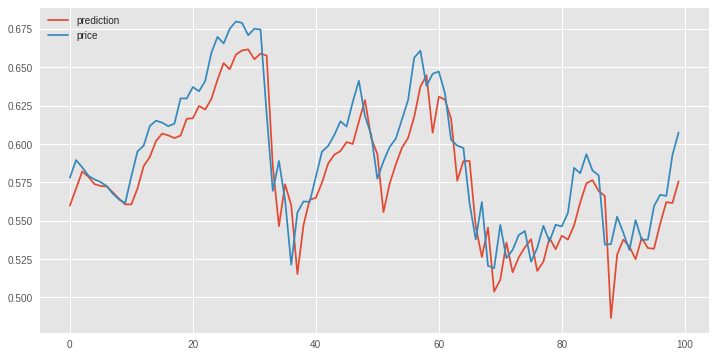

In [207]:
# Now that we trained our model let's feed in the testing data
test_sample = len(testX)
testing = testX.as_matrix()

# reshape our testing data for the LSTM
testing = testing.reshape(test_sample, 1, 5)

prediction = model.predict(testing)

# Let's plot our model's prediction against the test data
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(prediction))), prediction, label='prediction')
plt.plot(list(ranage(len(testY))), testY, label='price')
plt.legend(loc='upper left')
plt.show()

As we can see our model's prediction get's really close to the testing data!

So now what, we fitted a model to match this line. From here if we were a large trading firm, we could try to test this model with a small amount of money and see how much profit it makes. After that, we could then decide whether we should deploy it for real heavy use. Also, we could see if it predicts well in a simulated environment.

###<a id='4.2'>4.2 Saving our Model</a>

We don't want to keep having to train our model all the time so let's save our model. To do this we're going to use a package called Pickle and some code from some  guy i found on Google named <a href='http://zachmoshe.com/2017/04/03/pickling-keras-models.html'>Zach Moshe</a>. Below we run his code.

In [0]:
import types
import tempfile
import keras.models

def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            keras.models.save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = { 'model_str': model_str }
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = keras.models.load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = keras.models.Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

make_keras_picklable()

In [0]:
# Now we can use pickle to save the model
pickle.dump(model, open('stock_model.sav', 'wb'))

# This allows us to download the model from colaboratory
# Hint: Try using chrome when using this
files.download('stock_model.sav')

Now we should have a file on our computer that stores our model. If we ever decided to load the model at a later time then we can load it using the pickle.load() function.

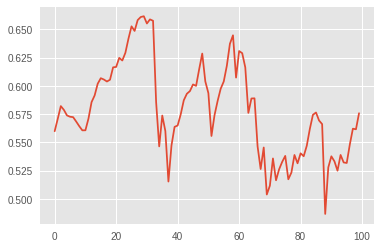

In [209]:
# Load our model from the pickled file
model2 = pickle.load(open('stock_model.sav', 'rb'))

# Let's plot the prediction of the loaded model
# to demonstrate that it still works
plt.figure()
plt.plot(range(100), model2.predict(testing))
plt.show()